# Script to read in Ecotech Data: 

ECOTECH data files read and clean

ECOtech data starts on **2018-04-22**

The NOAA software processes the data. 

- read in the data 
- exaimine the instrumental flags ('F1_S13')
- examine the instrument digital state 
- impose an RH threshold of 40%
- preiods with erronous data were removed:
    - '2018-11-13 00:00:00' < x < '2018-12-31 23:59:59'
    - '2019-01-01 00:00:00' <  x < '2019-03-21 00:00:00'
    - '2021-05-01 00:00:00' < x < '2021-11-01 00:00:00'


- There was a problem with the ECOTECH Neph in 2020/2021. For Oct and Nov 2020 the data is available in a different format (on hard drive under ‘Dumbo’).
- Dumbo format is corrected for STP using temp_var='T_S13' & press_var='P_S13'

- Dumbo and the rest are concantated 
- the rows with '9999.99' are removed

- Correction factor for Angular Nonidealities with Muller et al. 2011
- If CF < 1, then CF is set to 1.0

- All possible SAE are calculated 
- All possible conversions using the respective SAE

The aerosol particle scattering coefficients were measured using a three wavelength integrating nephelometer (Aurora Ecotech 3000) operating at 450, 525, and 635 nm.

The Aurora 4000 is the next generation of nephelometers incorporating integrated nephelometry (3 wavelengths 450nm, 525nm, 635nm) 

Range Measurement: 0 to 20,000 Mm-1
Lower Detectable Limit
< 0.3 Mm-1 over 60 seconds integration
< 0.1 Mm-1 over 60 seconds integration (Optional)

Data were corrected for truncation errors according to Anderson
184 and Ogren (1998), using the tabulated factors for total scatter as a linear function of Angstrom
185 exponent with no cutoff at the inlet (Rizzo et al., 2011; 2013).

- There is no Kalmar filtering.
- The assumption that the values need to be corrected is made
- Detection limits are applied on 5 minutes
- The normal mode is assumed to 7 and '7'

There was a problem with the ECOTECH Neph in 2020/2021, however the data gap should not be as big. For 2021 are data from May 2021 available (on the hard drive). And for Oct and Nov 2020 are data available however in a different format (on hard drive under ‘Dumbo’).
Are you in the office? I can give you the data till Dec 2022.

https://gml.noaa.gov/aero/software/aerosols/cpd2flags.html#ecotech_neph

In [1]:
import numpy as np
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import glob
import csv
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
import matplotlib.ticker as ticker
import cmocean
from scipy import stats
from datetime import datetime
import matplotlib.dates as mdates
import os

In [2]:
def thickax(ax, fontsize = 12):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    plt.rc('axes', linewidth=1.5)    
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='in', length=7, width=1.5, pad=12, bottom=True, top=True, left=True, right=True)

In [3]:
def fancy(ax, fontsize=20):    
    # thickning the axes spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color('k')        
    # set the fontsize for all your ticks    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)        
    # properties of the ticks
    ax.tick_params(direction='out', length=8, width=2, pad=10, bottom=True, top=False, left=True, right=False, color='k')    
    # add a grid to the plot
    ax.grid(True, alpha=0.5)  

In [4]:
#paths to load
ecotech_path = 'C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Data\\Neph\\ECOTECH\\'
TSI_path = 'C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Data\\Neph\\TSI\\'

DUMBO_ecotech_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\DUMBO'

out_path_plots = "C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Data\\processed_data\\plots\\TSI_Ecotech\\"
outpath_files = "C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Neph\\ecotech\\"

Ecotech_blue, Ecotech_green, Ecotech_red = 450, 525, 635 
TSI_blue, TSI_green, TSI_red = 450, 550, 700

TSI_color = 'b'
ecotech_color = 'r'

In [5]:
dict_abs_labels = {'BsB_S13':'$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(Ecotech_blue)+' nm) [Mm$^{-1}$]',
                   'BsB_S41':'$\sigma_{\mathrm{sp}}$ (TSI, '+str(TSI_blue)+' nm) [Mm$^{-1}$]',
                   'BsG_S13':'$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(Ecotech_green)+' nm) [Mm$^{-1}$]',
                   'BsG_S41':'$\sigma_{\mathrm{sp}}$ (TSI, '+str(TSI_green)+' nm) [Mm$^{-1}$]',
                   'BsR_S13':'$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(Ecotech_red)+' nm) [Mm$^{-1}$]',
                   'BsR_S41':'$\sigma_{\mathrm{sp}}$ (TSI, '+str(TSI_red)+' nm) [Mm$^{-1}$]',
                   'T_S13': 'Sample temperature (°C) (Ecotech)',
                   'U_S13':'Sample RH (%)  (Ecotech)',
                   'P_S13' : 'Sample pressure (hPa)  (Ecotech)',
                   'T_S41': 'Sample temperature (°C) (TSI)',
                   'U_S41':'Sample RH (%)  (TSI)',
                   'P_S41' : 'Sample pressure (hPa)  (TSI)',
                   'Uu_S41':'Sample RH (%)  (TSI)',
                   'BbsB_S13':'$\sigma_{\mathrm{bsp}}$ (Ecotech, '+str(Ecotech_blue)+' nm) [Mm$^{-1}$]',
                   'BbsG_S13':'$\sigma_{\mathrm{bsp}}$ (Ecotech, '+str(Ecotech_green)+' nm) [Mm$^{-1}$]', 
                   'BbsR_S13':'$\sigma_{\mathrm{bsp}}$ (Ecotech, '+str(Ecotech_red)+' nm) [Mm$^{-1}$]',
                   'BbsB_S41':'$\sigma_{\mathrm{bsp}}$ (TSI, '+str(TSI_blue)+' nm) [Mm$^{-1}$]', 
                   'BbsG_S41':'$\sigma_{\mathrm{bsp}}$ (TSI, '+str(TSI_green)+' nm) [Mm$^{-1}$]', 
                   'BbsR_S41':'$\sigma_{\mathrm{bsp}}$ (TSI, '+str(TSI_red)+' nm) [Mm$^{-1}$]'}

In [6]:
varlist = ['scat450', 'scat525', 'scat635','bscat450','bscat525','bscat635', 'T_int','RH_sample', 'P_int']

graph_titles = ['Scattering Coefficient $\sigma_{\mathrm{sp}}$ 450$\,$nm [Mm$^{-1}$]', 
                'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 525$\,$nm [Mm$^{-1}$]', 
                'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 635$\,$nm [Mm$^{-1}$]',
                'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 450$\,$nm [Mm$^{-1}$]',
                'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 525$\,$nm [Mm$^{-1}$]',
                'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 635$\,$nm [Mm$^{-1}$]',
                'Inlet Pressure [mbar]', 'Inlet Temperature [$\degree$C]', 'Inlet Relative Humidity [%]']

y_labels = ['[Mm$^{-1}$]','[Mm$^{-1}$]','[Mm$^{-1}$]','[Mm$^{-1}$]','[Mm$^{-1}$]','[Mm$^{-1}$]','[mbar]','[$\degree$C]','[%]']

In [7]:
dict_var_to_graph_titles = {'scat450':'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 450$\,$nm [Mm$^{-1}$]', 
                'scat525':'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 525$\,$nm [Mm$^{-1}$]', 
                'scat635':'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 635$\,$nm [Mm$^{-1}$]',
                'bscat450':'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 450$\,$nm [Mm$^{-1}$]',
                'bscat525':'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 525$\,$nm [Mm$^{-1}$]',
                'bscat635':'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 635$\,$nm [Mm$^{-1}$]',
                'P_int':'Inlet Pressure [mbar]', 'T_int':'Inlet Temperature [$\degree$C]', 
                'RH_sample':'Inlet Relative Humidity [%]',
                'scat550':'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 550$\,$nm [Mm$^{-1}$]', 
                'scat700':'Scattering Coefficient $\sigma_{\mathrm{sp}}$ 700$\,$nm [Mm$^{-1}$]',
                'bscat550':'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 550$\,$nm [Mm$^{-1}$]',
                'bscat700':'Backscattering Coefficient $\sigma_{\mathrm{bsp}}$ 700$\,$nm [Mm$^{-1}$]',
                'P_int':'Inlet Pressure [mbar]', 'T_int':'Inlet Temperature [$\degree$C]', 
                'RH_sample':'Inlet Relative Humidity [%]'}

In [8]:
[*dict_var_to_graph_titles.keys()]

['scat450',
 'scat525',
 'scat635',
 'bscat450',
 'bscat525',
 'bscat635',
 'P_int',
 'T_int',
 'RH_sample',
 'scat550',
 'scat700',
 'bscat550',
 'bscat700']

In [9]:
dict_abs_labels

{'BsB_S13': '$\\sigma_{\\mathrm{sp}}$ (Ecotech, 450 nm) [Mm$^{-1}$]',
 'BsB_S41': '$\\sigma_{\\mathrm{sp}}$ (TSI, 450 nm) [Mm$^{-1}$]',
 'BsG_S13': '$\\sigma_{\\mathrm{sp}}$ (Ecotech, 525 nm) [Mm$^{-1}$]',
 'BsG_S41': '$\\sigma_{\\mathrm{sp}}$ (TSI, 550 nm) [Mm$^{-1}$]',
 'BsR_S13': '$\\sigma_{\\mathrm{sp}}$ (Ecotech, 635 nm) [Mm$^{-1}$]',
 'BsR_S41': '$\\sigma_{\\mathrm{sp}}$ (TSI, 700 nm) [Mm$^{-1}$]',
 'T_S13': 'Sample temperature (°C) (Ecotech)',
 'U_S13': 'Sample RH (%)  (Ecotech)',
 'P_S13': 'Sample pressure (hPa)  (Ecotech)',
 'T_S41': 'Sample temperature (°C) (TSI)',
 'U_S41': 'Sample RH (%)  (TSI)',
 'P_S41': 'Sample pressure (hPa)  (TSI)',
 'Uu_S41': 'Sample RH (%)  (TSI)',
 'BbsB_S13': '$\\sigma_{\\mathrm{bsp}}$ (Ecotech, 450 nm) [Mm$^{-1}$]',
 'BbsG_S13': '$\\sigma_{\\mathrm{bsp}}$ (Ecotech, 525 nm) [Mm$^{-1}$]',
 'BbsR_S13': '$\\sigma_{\\mathrm{bsp}}$ (Ecotech, 635 nm) [Mm$^{-1}$]',
 'BbsB_S41': '$\\sigma_{\\mathrm{bsp}}$ (TSI, 450 nm) [Mm$^{-1}$]',
 'BbsG_S41': '$\\sigma_

In [10]:
#intsupport@ecotech.com

In [11]:
#Epoch time = EPOCH
#Fractional day of year (Midnight January 1 UTC = 1.00000) = DOY
#Instrument flags = F1_S13
#Instrument digital state = F2_S13
#Aerosol light scattering coefficient (Mm⁻¹) = BsB_S13
#Aerosol light scattering coefficient (Mm⁻¹) = BsG_S13
#Aerosol light scattering coefficient (Mm⁻¹) = BsR_S13
#Aerosol light backwards-hemispheric scattering coefficient (Mm⁻¹) = BbsB_S13
#Aerosol light backwards-hemispheric scattering coefficient (Mm⁻¹) = BbsG_S13
#Aerosol light backwards-hemispheric scattering coefficient (Mm⁻¹) = BbsR_S13
#"Spancheck sensitivity factor, defined as the photon count rate attributable to Rayleigh scattering by air at STP (Hz)" = CcB_S13
#"Spancheck sensitivity factor, defined as the photon count rate attributable to Rayleigh scattering by air at STP (Hz)" = CcG_S13
#"Spancheck sensitivity factor, defined as the photon count rate attributable to Rayleigh scattering by air at STP (Hz)" = CcR_S13
#"Spancheck backwards-hemispheric sensitivity factor, defined as the photon count rate attributable to Rayleigh backwards-hemispheric by air at STP (Hz)" = CbcB_S13
#"Spancheck backwards-hemispheric sensitivity factor, defined as the photon count rate attributable to Rayleigh backwards-hemispheric by air at STP (Hz)" = CbcG_S13
#"Spancheck backwards-hemispheric sensitivity factor, defined as the photon count rate attributable to Rayleigh backwards-hemispheric by air at STP (Hz)" = CbcR_S13
#Sample temperature (°C) = T_S13
#Sample RH (%) = U_S13
#Sample pressure (hPa) = P_S13
#Aerosol light backwards-hemispheric scattering coefficient from wall signal (Mm⁻¹)
#Aerosol light backwards-hemispheric scattering coefficient from wall signal (Mm⁻¹)
#Aerosol light backwards-hemispheric scattering coefficient from wall signal (Mm⁻¹)
#Aerosol light scattering coefficient from wall signal (Mm⁻¹)
#Aerosol light scattering coefficient from wall signal (Mm⁻¹)
#Aerosol light scattering coefficient from wall signal (Mm⁻¹)
#Dark count rate (Hz)
#Measurement backwards-hemispheric count rate (Hz)
#Measurement backwards-hemispheric count rate (Hz)
#Measurement backwards-hemispheric count rate (Hz)
#Reference shutter count rate (Hz)
#Reference shutter count rate (Hz)
#Reference shutter count rate (Hz)
#Measurement count rate (Hz)
#Measurement count rate (Hz)
#Measurement count rate (Hz)
#Spancheck backwards-hemispheric light scattering coefficient percent error (%)
#Spancheck backwards-hemispheric light scattering coefficient percent error (%)
#Spancheck backwards-hemispheric light scattering coefficient percent error (%)
#Spancheck total light scattering coefficient percent error (%)
#Spancheck total light scattering coefficient percent error (%)
#Spancheck total light scattering coefficient percent error (%)
#Sample pressure during zero (hPa)
#Sample temperature during zero (°C)
#Cell temperature (°C)
#Instrument calibration parameter data
#Full spancheck results
#EPOCH	DOY	F1_S13	F2_S13	BsB_S13	BsG_S13	BsR_S13	BbsB_S13	BbsG_S13	BbsR_S13	CcB_S13	CcG_S13	CcR_S13	CbcB_S13	CbcG_S13	CbcR_S13	T_S13	U_S13	P_S13	BbswB_S13	BbswG_S13	BbswR_S13	BswB_S13	BswG_S13	BswR_S13	CD_S13	CbsB_S13	CbsG_S13	CbsR_S13	CfB_S13	CfG_S13	CfR_S13	CsB_S13	CsG_S13	CsR_S13	PCTbcB_S13	PCTbcG_S13	PCTbcR_S13	PCTcB_S13	PCTcG_S13	PCTcR_S13	Pw_S13	Tw_S13	Tx_S13	ZPARAMETERS_S13	ZSPANCHECK_S13

In [12]:
dict_name_to_var = {
'Epoch time':'EPOCH',
'Fractional day of year (Midnight January 1 UTC 1.00000)':'DOY',
'Instrument flags':'F1_S13',
'Instrument digital state':'F2_S13',
'Aerosol light scattering coefficient (Mm⁻¹)':'BsB_S13',
'Aerosol light scattering coefficient (Mm⁻¹)':'BsG_S13',
'Aerosol light scattering coefficient (Mm⁻¹)':'BsR_S13',
'Aerosol light backwards-hemispheric scattering coefficient (Mm⁻¹)':'BbsB_S13',
'Aerosol light backwards-hemispheric scattering coefficient (Mm⁻¹)':'BbsG_S13',
'Aerosol light backwards-hemispheric scattering coefficient (Mm⁻¹)':'BbsR_S13',
"Spancheck sensitivity factor, defined as the photon count rate attributable to Rayleigh scattering by air at STP (Hz)":'CcB_S13',
"Spancheck sensitivity factor, defined as the photon count rate attributable to Rayleigh scattering by air at STP (Hz)":'CcG_S13',
"Spancheck sensitivity factor, defined as the photon count rate attributable to Rayleigh scattering by air at STP (Hz)":'CcR_S13',
"Spancheck backwards-hemispheric sensitivity factor, defined as the photon count rate attributable to Rayleigh backwards-hemispheric by air at STP (Hz)":'CbcB_S13',
"Spancheck backwards-hemispheric sensitivity factor, defined as the photon count rate attributable to Rayleigh backwards-hemispheric by air at STP (Hz)":'CbcG_S13',
"Spancheck backwards-hemispheric sensitivity factor, defined as the photon count rate attributable to Rayleigh backwards-hemispheric by air at STP (Hz)":'CbcR_S13',
'Sample temperature (°C)':'T_S13',
'Sample RH (%)':'U_S13',
'Sample pressure (hPa)':'P_S13',
'Aerosol light backwards-hemispheric scattering coefficient from wall signal (Mm⁻¹)':'BbswB_S13',
'Aerosol light backwards-hemispheric scattering coefficient from wall signal (Mm⁻¹)':'BbswG_S13',
'Aerosol light backwards-hemispheric scattering coefficient from wall signal (Mm⁻¹)':'BbswR_S13',
'Aerosol light scattering coefficient from wall signal (Mm⁻¹)':'BswB_S13',
'Aerosol light scattering coefficient from wall signal (Mm⁻¹)':'BswG_S13',
'Aerosol light scattering coefficient from wall signal (Mm⁻¹)':'BswR_S13',
'Dark count rate (Hz)':'CD_S13',
'Measurement backwards-hemispheric count rate (Hz)':'CbsB_S13',
'Measurement backwards-hemispheric count rate (Hz)':'CbsG_S13',
'Measurement backwards-hemispheric count rate (Hz)':'CbsR_S13',
'Reference shutter count rate (Hz)':'CfB_S13',
'Reference shutter count rate (Hz)':'CfG_S13',
'Reference shutter count rate (Hz)':'CfR_S13',
'Measurement count rate (Hz)':'CsB_S13',
'Measurement count rate (Hz)':'CsG_S13',
'Measurement count rate (Hz)':'CsR_S13',
'Spancheck backwards-hemispheric light scattering coefficient percent error (%)':'PCTbcB_S13',
'Spancheck backwards-hemispheric light scattering coefficient percent error (%)':'PCTbcG_S13',
'Spancheck backwards-hemispheric light scattering coefficient percent error (%)':'PCTbcR_S13',
'Spancheck total light scattering coefficient percent error (%)':'PCTcB_S13',
'Spancheck total light scattering coefficient percent error (%)':'PCTcG_S13',
'Spancheck total light scattering coefficient percent error (%)':'PCTcR_S13',
'Sample pressure during zero (hPa)':'Pw_S13',
'Sample temperature during zero (°C)':'Tw_S13',
'Cell temperature (°C)':'Tx_S13',
'Instrument calibration parameter data':'ZPARAMETERS_S13',
'Full spancheck results':'ZSPANCHECK_S13',
}

# Ecotech: Append data

The data avaiable includes ECOTECH data starting from April 2018 until June 2019

In [13]:
"""As some of the results files come in the same file with a repeating header
they need to be separate according by finding the lines which start with either 
FID1 or Sample and using the index of these lines"""


def find_indexs(file, string_in_line):
    file_info = open(file, 'r', encoding="utf8")
    lines = file_info.readlines()
    file_size = len(lines)    
    for i, line in enumerate(lines):         
        if string_in_line in line:
            skip_index = i
        else:
            pass
    return skip_index

In [14]:
def read_and_append_ecotech_data(ecotech_path, years=[2018,2019, 2020]):
    print(ecotech_path+'year\\*.txt')
    appended_ecotech_data=[]
    for year in years:
        print("year: "+str(year))
        for name_file in glob.glob(ecotech_path+str(year)+'\\TXTformat\\*.txt'): ##2019\\TXTformat\\'
            print("Name: "+str(name_file))
            skip_index = find_indexs(name_file, string_in_line='name')
            print("skip index: "+str(skip_index))
            if skip_index == 1:        
                df = pd.read_csv(name_file, sep='\s+',skiprows=skip_index, parse_dates=[['!row', 'name']])
                df = df.rename(columns={'!row_name':'Datetime'})
                df.DOY = pd.to_datetime(str(year)+'-01-01') + pd.to_timedelta(df.DOY, unit='D') #convert date of year
                appended_ecotech_data.append(df)    
            else:    
                df = pd.read_csv(name_file, sep=',',skiprows=skip_index, parse_dates=['!row;name'])
                df = df.rename(columns={'!row;name':'Datetime'})
                df.DOY = pd.to_datetime(str(year)+'-01-01') + pd.to_timedelta(df.DOY, unit='D') #convert date of year
                appended_ecotech_data.append(df)    
    appended_ecotech_data = pd.concat(appended_ecotech_data, axis=0)
    appended_ecotech_data.index = pd.to_datetime(appended_ecotech_data['DOY'], format='%Y-%m-%d %H:%M:%S') #DOY correct, not given datetime
    return appended_ecotech_data

In [15]:
appended_ecotech_data = read_and_append_ecotech_data(ecotech_path, years=[2018,2019, 2020, 2021, 2022])

C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\year\*.txt
year: 2018
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_111.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_112.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_113.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_114.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_115.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_117.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_118.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP

Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_179.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_180.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_181.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_182.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_183.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_184.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_185.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_186.txt
skip index: 1
Name: C:

Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_265.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_266.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_267.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_268.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_269.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_270.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_271.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_272.txt
skip index: 1
Name: C:

Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_336.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_337.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_338.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_339.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_340.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_341.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_342.txt
skip index: 1
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2018\TXTformat\ZEP_NEPH-ECOTECH_343.txt
skip index: 1
Name: C:

<ipython-input-15-30fc2cba67dc>:1: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  appended_ecotech_data = read_and_append_ecotech_data(ecotech_path, years=[2018,2019, 2020, 2021, 2022])


Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2021\TXTformat\ZEP_NEPH-ECOTECH_202107.txt
skip index: 6
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2021\TXTformat\ZEP_NEPH-ECOTECH_202108.txt
skip index: 6
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2021\TXTformat\ZEP_NEPH-ECOTECH_202109.txt
skip index: 6
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2021\TXTformat\ZEP_NEPH-ECOTECH_202110.txt
skip index: 6
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2021\TXTformat\ZEP_NEPH-ECOTECH_202111.txt
skip index: 6
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2021\TXTformat\ZEP_NEPH-ECOTECH_202112.txt
skip index: 6
year: 2022
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2022\TXTformat\ZEP_NEPH-ECOTECH_202201.txt
skip index: 6
Name: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\Neph\ECOTECH\2022\TXTformat\ZEP_NEPH-ECOTEC

In [16]:
appended_ecotech_data.columns

Index(['Datetime', 'EPOCH', 'DOY', 'F1_S13', 'F2_S13', 'BsB_S13', 'BsG_S13',
       'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13', 'CcB_S13', 'CcG_S13',
       'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13', 'T_S13', 'U_S13',
       'P_S13', 'BbswB_S13', 'BbswG_S13', 'BbswR_S13', 'BswB_S13', 'BswG_S13',
       'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13', 'CbsR_S13', 'CfB_S13',
       'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13', 'CsR_S13', 'PCTbcB_S13',
       'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13', 'PCTcG_S13', 'PCTcR_S13',
       'Pw_S13', 'Tw_S13', 'Tx_S13', 'ZPARAMETERS_S13', 'ZSPANCHECK_S13',
       'Cd_S13', 'ZEE_S13'],
      dtype='object')

In [17]:
dict_col_to_max = {}

cols = ['Datetime', 'EPOCH', 'DOY', 'F1_S13', 'F2_S13', 'BsB_S13', 'BsG_S13',
       'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13', 'CcB_S13', 'CcG_S13',
       'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13', 'T_S13', 'U_S13',
       'P_S13', 'BbswB_S13', 'BbswG_S13', 'BbswR_S13', 'BswB_S13', 'BswG_S13',
       'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13', 'CbsR_S13', 'CfB_S13',
       'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13', 'CsR_S13', 'PCTbcB_S13',
       'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13', 'PCTcG_S13', 'PCTcR_S13',
       'Pw_S13', 'Tw_S13', 'Tx_S13', 'ZPARAMETERS_S13', 'ZSPANCHECK_S13',
       'Cd_S13', 'ZEE_S13']
for col in cols:
    if appended_ecotech_data[col].dtype != np.dtype('<M8[ns]'):
        max_digits = appended_ecotech_data[col].astype(str).str.len().max()
        dict_col_to_max[col] = max_digits
print(dict_col_to_max)

{'EPOCH': 10, 'F1_S13': 8, 'F2_S13': 2, 'BsB_S13': 8, 'BsG_S13': 8, 'BsR_S13': 8, 'BbsB_S13': 8, 'BbsG_S13': 8, 'BbsR_S13': 9, 'CcB_S13': 7, 'CcG_S13': 7, 'CcR_S13': 7, 'CbcB_S13': 7, 'CbcG_S13': 7, 'CbcR_S13': 7, 'T_S13': 4, 'U_S13': 4, 'P_S13': 6, 'BbswB_S13': 8, 'BbswG_S13': 8, 'BbswR_S13': 9, 'BswB_S13': 8, 'BswG_S13': 8, 'BswR_S13': 8, 'CD_S13': 9, 'CbsB_S13': 8, 'CbsG_S13': 8, 'CbsR_S13': 8, 'CfB_S13': 8, 'CfG_S13': 8, 'CfR_S13': 8, 'CsB_S13': 8, 'CsG_S13': 8, 'CsR_S13': 8, 'PCTbcB_S13': 6, 'PCTbcG_S13': 6, 'PCTbcR_S13': 6, 'PCTcB_S13': 6, 'PCTcG_S13': 6, 'PCTcR_S13': 6, 'Pw_S13': 6, 'Tw_S13': 4, 'Tx_S13': 5, 'ZPARAMETERS_S13': 9, 'ZSPANCHECK_S13': 9, 'Cd_S13': 10, 'ZEE_S13': 9}


In [18]:
appended_ecotech_data['Datetime'].dtype

dtype('<M8[ns]')

In [19]:
np.finfo(np.float32).precision

6

In [20]:
a = np.array([0.123456789121212,], dtype=np.float16)
print("16bit: ", a[0])
a = np.array([0.123456789121212,], dtype=np.float32)
print("32bit: ", a[0])
b = np.array([0.123456789121212121212,], dtype=np.float64)
print("64bit: ", b[0])

16bit:  0.1235
32bit:  0.12345679
64bit:  0.12345678912121212


In [21]:
print(appended_ecotech_data.columns)

Index(['Datetime', 'EPOCH', 'DOY', 'F1_S13', 'F2_S13', 'BsB_S13', 'BsG_S13',
       'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13', 'CcB_S13', 'CcG_S13',
       'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13', 'T_S13', 'U_S13',
       'P_S13', 'BbswB_S13', 'BbswG_S13', 'BbswR_S13', 'BswB_S13', 'BswG_S13',
       'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13', 'CbsR_S13', 'CfB_S13',
       'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13', 'CsR_S13', 'PCTbcB_S13',
       'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13', 'PCTcG_S13', 'PCTcR_S13',
       'Pw_S13', 'Tw_S13', 'Tx_S13', 'ZPARAMETERS_S13', 'ZSPANCHECK_S13',
       'Cd_S13', 'ZEE_S13'],
      dtype='object')


## Max values: 

In [22]:
def remove_max_values(df):
    scat_cols = ['BsB_S13', 'BsG_S13', 'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13']
    print(df[scat_cols].max())
    df.loc[(df[scat_cols] > 1000).any(axis=1), scat_cols] = np.nan
    df.loc[(df[scat_cols] < -1000).any(axis=1), scat_cols] = np.nan
    print(len(df))
    df = df.dropna(subset=scat_cols)
    print(len(df))
    print(df[scat_cols].max())
    return df

In [23]:
appended_ecotech_data = remove_max_values(appended_ecotech_data)

BsB_S13      9999.99
BsG_S13      9999.99
BsR_S13      9999.99
BbsB_S13     9999.99
BbsG_S13     9999.99
BbsR_S13    14121.09
dtype: float64
1870305
1823901
BsB_S13     971.92
BsG_S13     838.23
BsR_S13     923.06
BbsB_S13    412.09
BbsG_S13    332.66
BbsR_S13    763.05
dtype: float64


In [24]:
dict_var_to_max = dict(appended_ecotech_data.max())
print(dict_var_to_max)

{'Datetime': Timestamp('2022-12-31 23:59:00'), 'EPOCH': 1672531140, 'DOY': Timestamp('2023-01-01 23:59:00.384000'), 'BsB_S13': 971.92, 'BsG_S13': 838.23, 'BsR_S13': 923.06, 'BbsB_S13': 412.09, 'BbsG_S13': 332.66, 'BbsR_S13': 763.05, 'CcB_S13': 99999.9, 'CcG_S13': 99999.9, 'CcR_S13': 99999.9, 'CbcB_S13': 99999.9, 'CbcG_S13': 99999.9, 'CbcR_S13': 99999.9, 'T_S13': 99.9, 'U_S13': 99.9, 'P_S13': 9999.9, 'BbswB_S13': 9999.99, 'BbswG_S13': 9999.99, 'BbswR_S13': 13874.75, 'BswB_S13': 9999.99, 'BswG_S13': 9999.99, 'BswR_S13': 9999.99, 'CD_S13': 9999999.0, 'CbsB_S13': 9999999, 'CbsG_S13': 9999999, 'CbsR_S13': 9999999, 'CfB_S13': 99999999, 'CfG_S13': 99999999, 'CfR_S13': 99999999, 'CsB_S13': 9999999, 'CsG_S13': 9999999, 'CsR_S13': 9999999, 'PCTbcB_S13': 999.99, 'PCTbcG_S13': 999.99, 'PCTbcR_S13': 999.99, 'PCTcB_S13': 999.99, 'PCTcG_S13': 999.99, 'PCTcR_S13': 999.99, 'Pw_S13': 9999.9, 'Tw_S13': 99.9, 'Tx_S13': 162.9, 'ZSPANCHECK_S13': 99999.999, 'Cd_S13': 464.0}


<ipython-input-24-47c4fb5927d1>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dict_var_to_max = dict(appended_ecotech_data.max())


In [25]:
def replace_max_numeric(df):
    print(df.max())
    df = df[df != 9999.99]
    cols = select_dtype_cols(df)
    print(cols)
    for col in cols:
        #print(col)        
        df[col] = df[col].replace(dict_var_to_max[col], np.nan) #replace the 9999.99 values
    print(df.max())
    return df

In [26]:
def select_dtype_cols(df):
    cols = df.loc[:, df.dtypes != np.dtype('O')].columns
    return cols

In [27]:
appended_ecotech_data = replace_max_numeric(appended_ecotech_data)

<ipython-input-25-6d961fec6701>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.max())


Datetime                 2022-12-31 23:59:00
EPOCH                             1672531140
DOY               2023-01-01 23:59:00.384000
BsB_S13                               971.92
BsG_S13                               838.23
BsR_S13                               923.06
BbsB_S13                              412.09
BbsG_S13                              332.66
BbsR_S13                              763.05
CcB_S13                              99999.9
CcG_S13                              99999.9
CcR_S13                              99999.9
CbcB_S13                             99999.9
CbcG_S13                             99999.9
CbcR_S13                             99999.9
T_S13                                   99.9
U_S13                                   99.9
P_S13                                 9999.9
BbswB_S13                            9999.99
BbswG_S13                            9999.99
BbswR_S13                           13874.75
BswB_S13                             9999.99
BswG_S13  

<ipython-input-25-6d961fec6701>:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.max())


In [28]:
def simple_plot(appended_ecotech_data, max_value=100):
    fig, ax = plt.subplots(1, figsize=(10,2))
    ax.plot(appended_ecotech_data.index, appended_ecotech_data['BsB_S13'],'o',ms=0.5)
    ax.set_ylim(-10,max_value)
    ax.set_ylabel(dict_abs_labels['BsB_S13'], fontsize=12)
    thickax(ax)
    plt.show()
    return fig

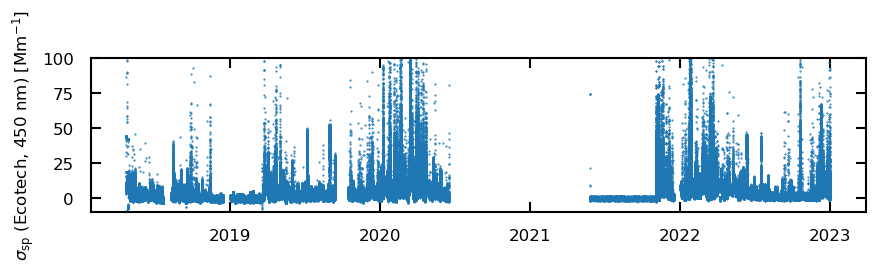

In [29]:
fig = simple_plot(appended_ecotech_data)

In [30]:
appended_ecotech_data.head(2)

,Datetime,EPOCH,DOY,F1_S13,F2_S13,BsB_S13,BsG_S13,BsR_S13,BbsB_S13,BbsG_S13,...,PCTcB_S13,PCTcG_S13,PCTcR_S13,Pw_S13,Tw_S13,Tx_S13,ZPARAMETERS_S13,ZSPANCHECK_S13,Cd_S13,ZEE_S13
DOY,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN
2018-04-22 14:10:02.784,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN


# Flags: 

'Instrument flags':'F1_S13'

In [31]:
def get_freq_flags(appended_ecotech_data):
    flags = appended_ecotech_data.F1_S13.unique()
    print(flags)
    print("type: "+str(type(flags[0])))
    flags_strings = [x for x in flags if type(x)==str]
    print(flags_strings)
    print(appended_ecotech_data.F1_S13.value_counts())
    df_freq_instrument_flags = appended_ecotech_data.F1_S13.value_counts().to_frame()
    return df_freq_instrument_flags

In [32]:
def bar_plot(df, var='F1_S13'):
    instrument_flags = df.index.values
    print(instrument_flags)
    freq = df[var].values
    print(freq)
    
    fig, ax = plt.subplots(figsize=(10,5))
    x = instrument_flags

    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, freq, color='green')
    plt.xlabel("Flags")
    plt.ylabel("Frequency [-]")
    plt.title("")
    plt.xticks(x_pos, x, rotation=90)
    plt.yscale('log')
    plt.show()
    return fig

['200' '03B50200' 'FFFFFFFF' '30000200' '03A80200' '80040200' '03BC0200'
 '03B20200' '03B30200' '03A60200' '03B60200' '03B70200' '03AF0200'
 '82000200' '03AE0200' '03B00200' '03C70200' '03B80200' '03C20200'
 '00000200' '03C00200' '03CC0200' '82700200' '03A30200' '03B40200'
 '039A0200' '03A70200' '03A10200' 200 '20000200' 20000200 80040200]
type: <class 'str'>
['200', '03B50200', 'FFFFFFFF', '30000200', '03A80200', '80040200', '03BC0200', '03B20200', '03B30200', '03A60200', '03B60200', '03B70200', '03AF0200', '82000200', '03AE0200', '03B00200', '03C70200', '03B80200', '03C20200', '00000200', '03C00200', '03CC0200', '82700200', '03A30200', '03B40200', '039A0200', '03A70200', '03A10200', '20000200']
00000200    695110
200         600321
200         526375
30000200      1658
FFFFFFFF       277
80040200        59
82000200        47
20000200        15
20000200         9
03B50200         3
82700200         2
80040200         2
03A80200         2
03B60200         2
03B20200         2
03AF0200 

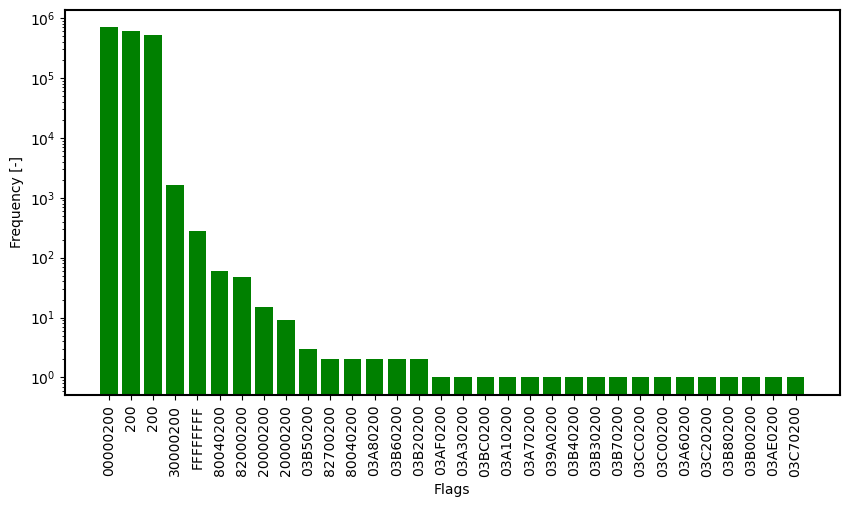

In [33]:
df_freq_instrument_flags = get_freq_flags(appended_ecotech_data)

fig = bar_plot(df_freq_instrument_flags, var='F1_S13')

## 'Instrument digital state':'F2_S13',:

     F2_S13
07  1295312
7    524149
7      3004
04      615
AB      352
93      209
4       130
03       58
FF       44
2B       10
4         9
93        8
90        1
['07' '7' 7 '04' 'AB' '93' '4' '03' 'FF' '2B' 4 93 '90']
[1295312  524149    3004     615     352     209     130      58      44
      10       9       8       1]


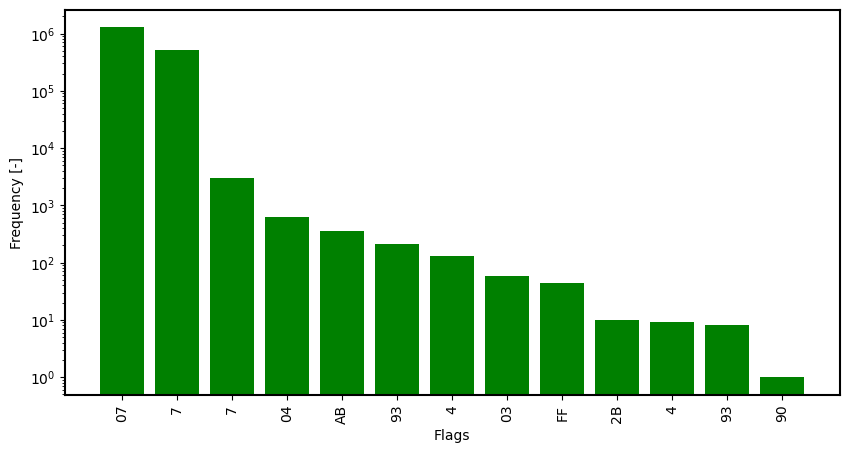

In [34]:
df_freq_Instrument_digital_state_flags = appended_ecotech_data['F2_S13'].value_counts().to_frame()
print(df_freq_Instrument_digital_state_flags)

fig = bar_plot(df_freq_Instrument_digital_state_flags, var='F2_S13')

In [35]:
def simple_plot_instrument_flags(df, flag_var='F1_S13', max_value=100, legend_cols=3):
    cmap='turbo'
   
    fig, ax = plt.subplots(1, figsize=(20,8))
    
    instrument_flags = df[flag_var].unique()
    number_of_colours = len(instrument_flags)    
    colors=plt.get_cmap(cmap)(np.linspace(0,1, int(number_of_colours)))
    dict_colours = dict(zip(instrument_flags, colors))
    for instrument_flag in instrument_flags:           
        df_flag = df[df[flag_var] == instrument_flag].copy()
        ax.plot(df_flag.index, df_flag['BsB_S13'],'o', ms=0.5, c=dict_colours[instrument_flag],
               label=str(instrument_flag))          
       
    ax.set_ylabel(dict_abs_labels['BsB_S13'], fontsize=25)
    fancy(ax) 
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=int(len(instrument_flags)/legend_cols),
            borderaxespad=0, frameon=False, markerscale=10,)
    #plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-07-22'))
    plt.tight_layout()
    plt.show()
    return fig

In [36]:
appended_ecotech_data.index

DatetimeIndex(['2018-04-22 14:10:00.192000', '2018-04-22 14:10:02.784000',
               '2018-04-22 14:10:23.520000', '2018-04-22 14:10:23.520000',
               '2018-04-22 14:10:23.520000', '2018-04-22 14:10:23.520000',
               '2018-04-22 14:10:23.520000', '2018-04-22 14:10:59.808000',
               '2018-04-22 14:12:00.288000', '2018-04-22 14:12:59.904000',
               ...
               '2023-01-01 23:50:00.384000',        '2023-01-01 23:51:00',
               '2023-01-01 23:51:59.616000', '2023-01-01 23:53:00.096000',
               '2023-01-01 23:53:59.712000', '2023-01-01 23:55:00.192000',
               '2023-01-01 23:55:59.808000', '2023-01-01 23:57:00.288000',
               '2023-01-01 23:57:59.904000', '2023-01-01 23:59:00.384000'],
              dtype='datetime64[ns]', name='DOY', length=1823901, freq=None)

In [37]:
def save_plot(fig, path=out_path_plots, folder='', 
              name='default_name', formate=".jpeg"):
    folders = glob.glob(path)
    print(folders)
    if folder not in folders:
        print("make folder")
        os.makedirs(path+"\\"+folder, exist_ok=True)
    fig.savefig(path+"\\"+folder+"\\"+str(name)+str(formate), bbox_inches='tight')
    print("saved as: "+str(path+"\\"+folder+"\\"+str(name)+str(formate)))

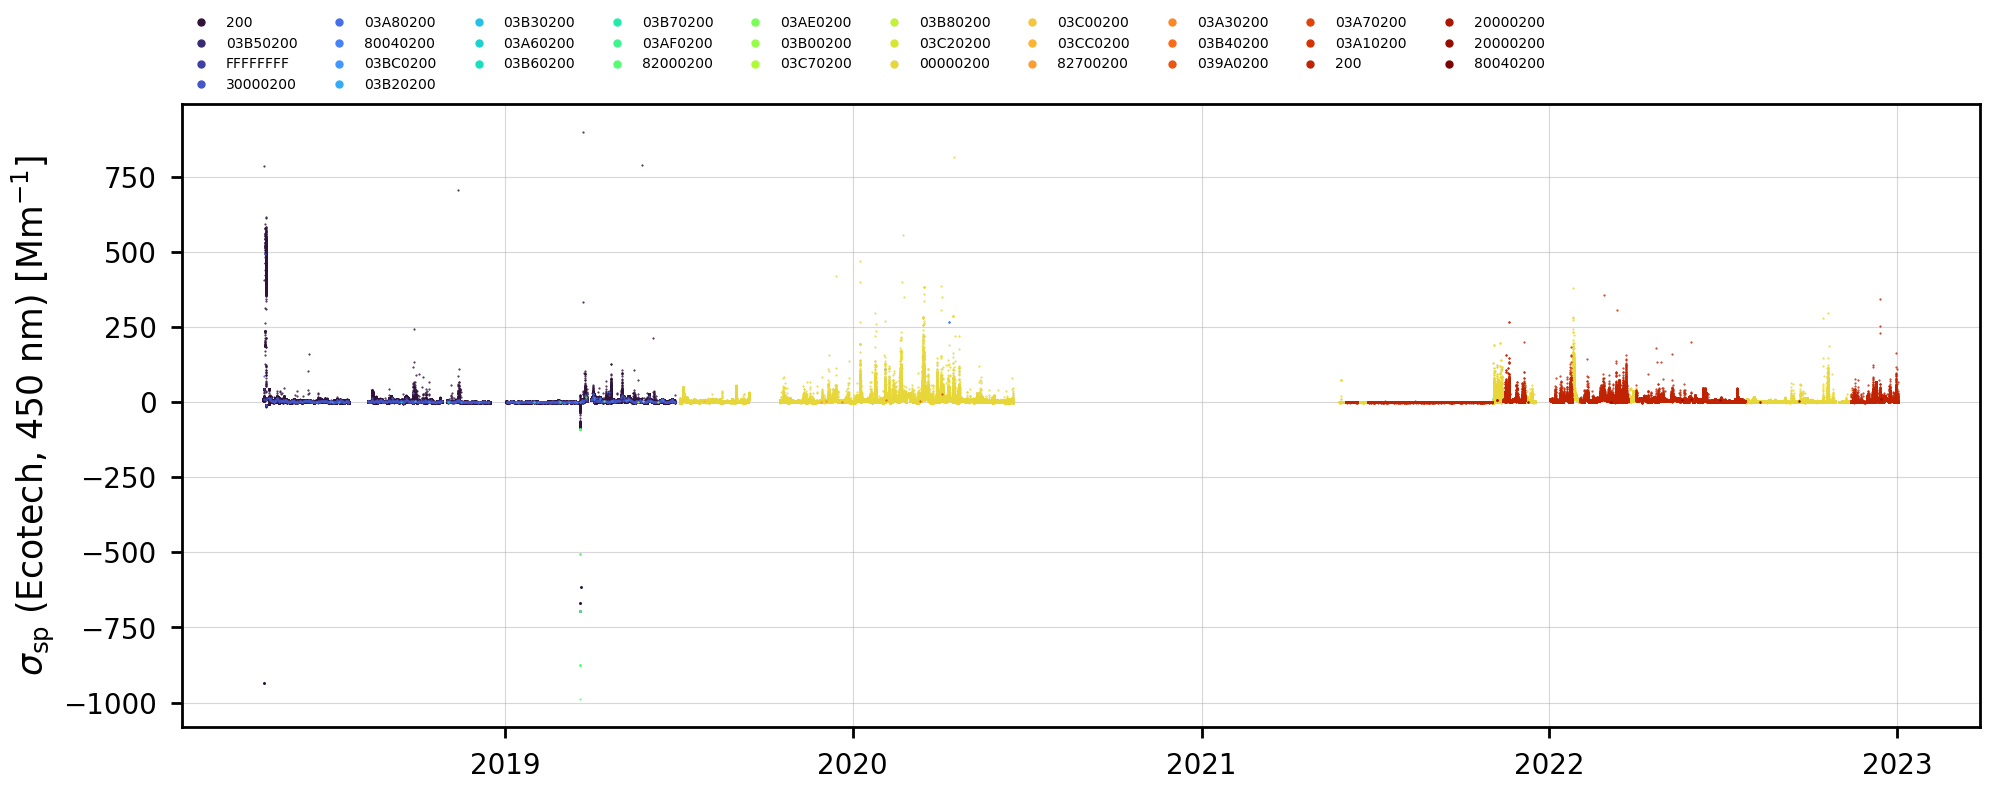

['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Data\\processed_data\\plots\\TSI_Ecotech\\']
make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\processed_data\plots\TSI_Ecotech\\\ecotech.jpeg


In [38]:
fig = simple_plot_instrument_flags(appended_ecotech_data, flag_var='F1_S13')
save_plot(fig, name='ecotech')

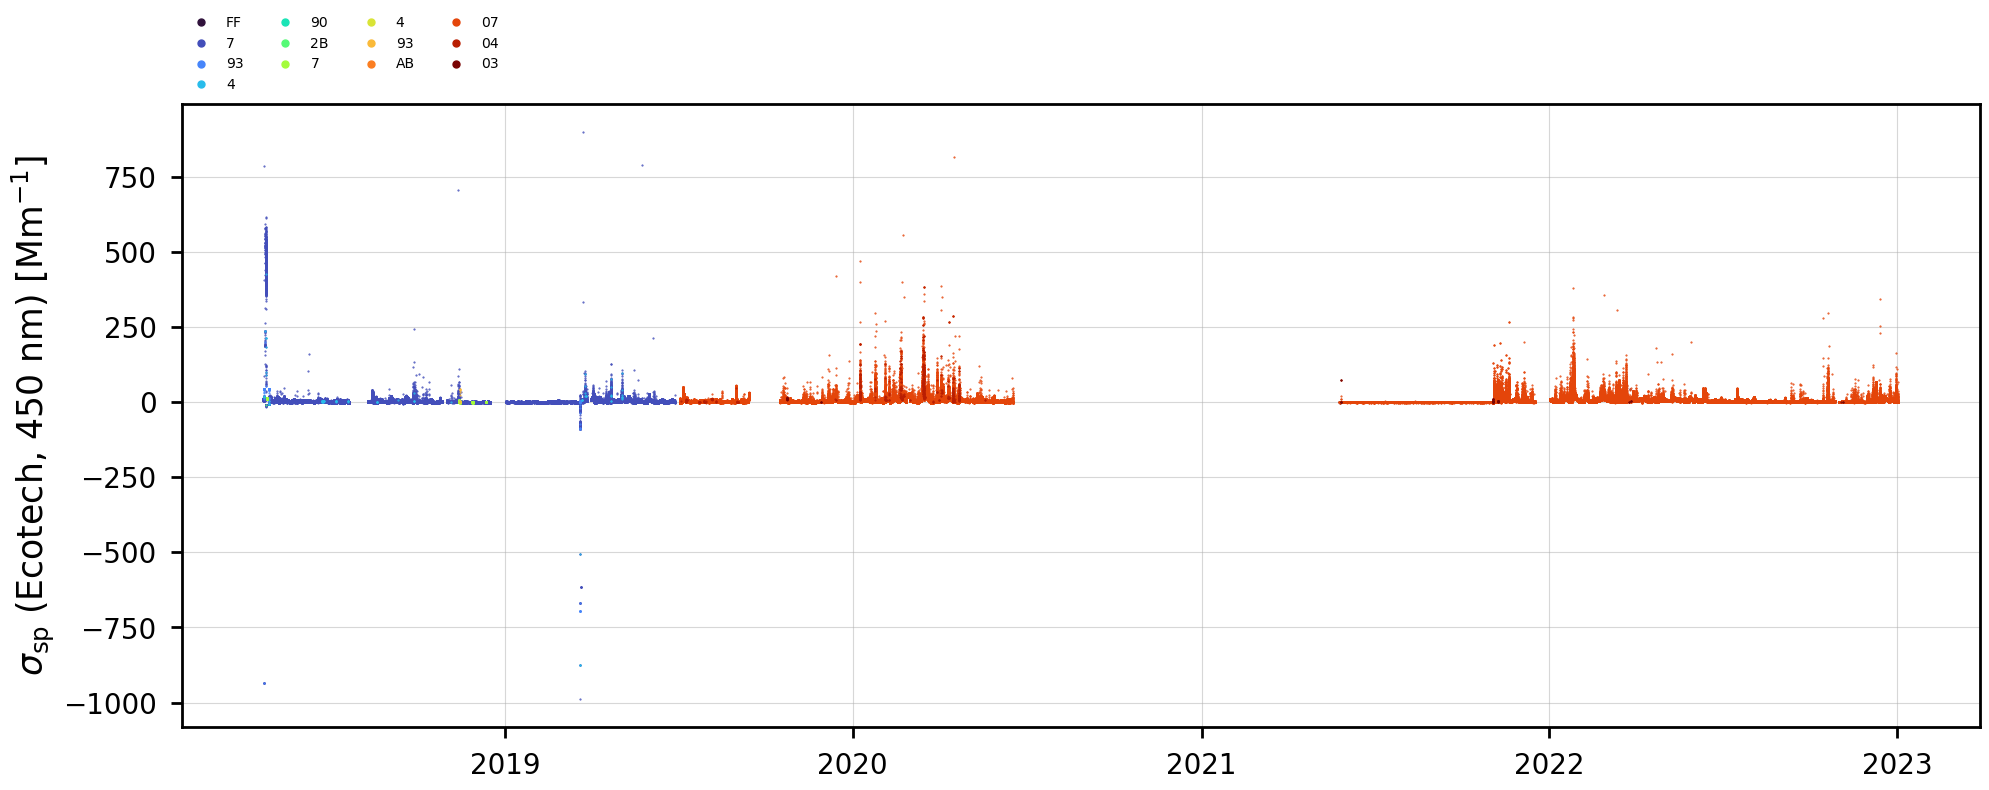

['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Data\\processed_data\\plots\\TSI_Ecotech\\']
make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\processed_data\plots\TSI_Ecotech\\\ecotech.jpeg


In [39]:
fig = simple_plot_instrument_flags(appended_ecotech_data, flag_var='F2_S13')
save_plot(fig, name='ecotech')

In [40]:
def simple_plot_instruments(df, flag_var='F1_S13', max_value=100, instrument_flags=None):
    cmap='turbo'
   
    fig, ax = plt.subplots(1, figsize=(20,8))
    
    if instrument_flags == None:
        instrument_flags = df[flag_var].unique()
    number_of_colours = len(instrument_flags)    
    colors=plt.get_cmap(cmap)(np.linspace(0,1, int(number_of_colours)))
    dict_colours = dict(zip(instrument_flags, colors))
    for instrument_flag in instrument_flags:        
        print(instrument_flag)        
        df_flag = df[df[flag_var] == instrument_flag].copy()
        ax.plot(df_flag.index, df_flag['BsB_S13'],'o', ms=2, c=dict_colours[instrument_flag],
               label=str(instrument_flag))          
       
    ax.set_ylabel(dict_abs_labels['BsB_S13'], fontsize=25)
    fancy(ax) 
    plt.legend(bbox_to_anchor=(1.1, 1), borderaxespad=0, markerscale=10, frameon=False)
    plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2020-07-22'))
    plt.show()
    return fig

In [41]:
df_freq_Instrument_digital_state_flags.index

Index(['07', '7', 7, '04', 'AB', '93', '4', '03', 'FF', '2B', 4, 93, '90'], dtype='object')

04


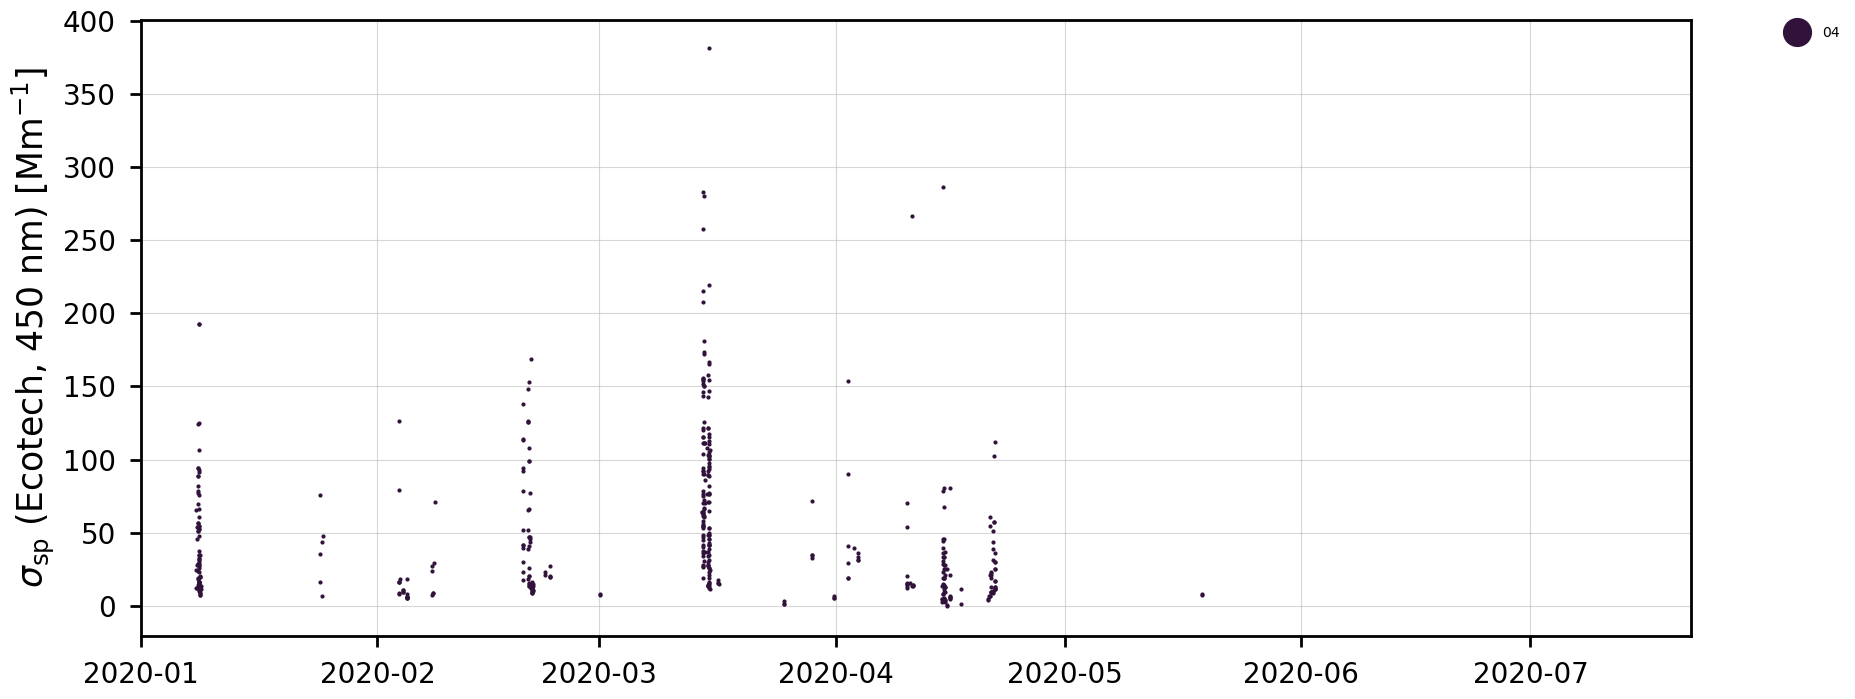

In [42]:
fig = simple_plot_instruments(appended_ecotech_data, flag_var='F2_S13', max_value=100, 
            instrument_flags=['04'])

# rh: 

In [43]:
def clean_for_RH(df, RH_col='U_S13', RH_threshold=40):
    ## clean for RH
    df = df[df[RH_col] < RH_threshold]
    return df

In [44]:
appended_ecotech_data = clean_for_RH(appended_ecotech_data, RH_col='U_S13', RH_threshold=40)

## Flags ECOtech

For the flags the first 4 digits reflect the nature of the flag e.g. xxxx0200. FFFFFFFF is unknown. Hence 200 must be equilivent to 200-0200 = 0. The instrumental flags should be as follows:
- 32768 (8000) SystemStatus
- 16384 (4000) Reserved
- 8192 (2000) Reserved
- 4096 (1000) Reserved 
- 2048 (0800) Reserved
- 1024 (0400) BackscatterHighWarning
- 512 (0200) WarmingUpStatus
- 256 (0100) PMTStatus
- 128 (0080) RHSensorStatus
- 64 (0040) SampleTempSensorStatus
- 32 (0020) EnclosureTempSensorStatus
- 16 (0010) PressureSensorStatus
- 8 (0008) LightSourceStatus
- 4 (0004) ShutterStatus
- 2 (0002) BackScatDigIOStatus
- 1 (0001) BackScatterStatus

In [45]:
flags = appended_ecotech_data.F1_S13.unique()
print(flags)
type(flags[0])

flags_strings = [x for x in flags if type(x)==str]
print(flags_strings)

['200' '03B50200' 'FFFFFFFF' '30000200' '03A80200' '80040200' '03BC0200'
 '03B20200' '03B30200' '03A60200' '03B60200' '03B70200' '03AF0200'
 '82000200' '03AE0200' '03B00200' '03C70200' '03B80200' '03C20200'
 '00000200' '03C00200' '03CC0200' '82700200' '03A30200' '03B40200'
 '039A0200' '03A70200' '03A10200' 200 '20000200' 20000200 80040200]
['200', '03B50200', 'FFFFFFFF', '30000200', '03A80200', '80040200', '03BC0200', '03B20200', '03B30200', '03A60200', '03B60200', '03B70200', '03AF0200', '82000200', '03AE0200', '03B00200', '03C70200', '03B80200', '03C20200', '00000200', '03C00200', '03CC0200', '82700200', '03A30200', '03B40200', '039A0200', '03A70200', '03A10200', '20000200']


In [46]:
def examine_flags(df):
    flags = df.F1_S13.unique()
    print(flags)
    flags_strings = [x for x in flags if type(x)==str]
    print(flags_strings)
    
    last_digits_removed = [x[:-4] for x in flags_strings]
    print(flags)
    print('\n')
    print(last_digits_removed)
    print('\n')
    decimal = [int(str(x),16) for x in last_digits_removed[1:]]
    print(decimal)
    print('\n')
    dict_flags_to_decimal = dict(zip(flags, decimal))
    print(dict_flags_to_decimal)
    print(df.F1_S13.value_counts())
    return flags, decimal
#dictionary_for_flags = {'':'All status pass', 'FFFF':'Unknown', '03B5':'', '2000', '3000', '03A8', 'A004', '8004', '03BC', '03B2', '03B3', '03A6', '03B6'}

In [47]:
flags, decimal = examine_flags(appended_ecotech_data)

['200' '03B50200' 'FFFFFFFF' '30000200' '03A80200' '80040200' '03BC0200'
 '03B20200' '03B30200' '03A60200' '03B60200' '03B70200' '03AF0200'
 '82000200' '03AE0200' '03B00200' '03C70200' '03B80200' '03C20200'
 '00000200' '03C00200' '03CC0200' '82700200' '03A30200' '03B40200'
 '039A0200' '03A70200' '03A10200' 200 '20000200' 20000200 80040200]
['200', '03B50200', 'FFFFFFFF', '30000200', '03A80200', '80040200', '03BC0200', '03B20200', '03B30200', '03A60200', '03B60200', '03B70200', '03AF0200', '82000200', '03AE0200', '03B00200', '03C70200', '03B80200', '03C20200', '00000200', '03C00200', '03CC0200', '82700200', '03A30200', '03B40200', '039A0200', '03A70200', '03A10200', '20000200']
['200' '03B50200' 'FFFFFFFF' '30000200' '03A80200' '80040200' '03BC0200'
 '03B20200' '03B30200' '03A60200' '03B60200' '03B70200' '03AF0200'
 '82000200' '03AE0200' '03B00200' '03C70200' '03B80200' '03C20200'
 '00000200' '03C00200' '03CC0200' '82700200' '03A30200' '03B40200'
 '039A0200' '03A70200' '03A10200' 200 '2

In keeping with the previous TSI clean. 0080 RHSensorStatus is kept i.e. '00800200'. The flags '20000200' (8192 in decimal) and '30000200' (12288 in decimal = 8192 + 4096) are the most common. These flags signify 'Reserved' (2000/8192) and 'Reserved' for 4096 

In [48]:
RH = appended_ecotech_data[appended_ecotech_data.F1_S13 ==  '00800200']
print(RH)

Empty DataFrame
Columns: [Datetime, EPOCH, DOY, F1_S13, F2_S13, BsB_S13, BsG_S13, BsR_S13, BbsB_S13, BbsG_S13, BbsR_S13, CcB_S13, CcG_S13, CcR_S13, CbcB_S13, CbcG_S13, CbcR_S13, T_S13, U_S13, P_S13, BbswB_S13, BbswG_S13, BbswR_S13, BswB_S13, BswG_S13, BswR_S13, CD_S13, CbsB_S13, CbsG_S13, CbsR_S13, CfB_S13, CfG_S13, CfR_S13, CsB_S13, CsG_S13, CsR_S13, PCTbcB_S13, PCTbcG_S13, PCTbcR_S13, PCTcB_S13, PCTcG_S13, PCTcR_S13, Pw_S13, Tw_S13, Tx_S13, ZPARAMETERS_S13, ZSPANCHECK_S13, Cd_S13, ZEE_S13]
Index: []

[0 rows x 49 columns]


Just allow the '200' flag

In [49]:
flags_removed_df = appended_ecotech_data[appended_ecotech_data.F1_S13 == '200']

In [50]:
appended_ecotech_data['F1_S13'].unique()

array(['200', '03B50200', 'FFFFFFFF', '30000200', '03A80200', '80040200',
       '03BC0200', '03B20200', '03B30200', '03A60200', '03B60200',
       '03B70200', '03AF0200', '82000200', '03AE0200', '03B00200',
       '03C70200', '03B80200', '03C20200', '00000200', '03C00200',
       '03CC0200', '82700200', '03A30200', '03B40200', '039A0200',
       '03A70200', '03A10200', 200, '20000200', 20000200, 80040200],
      dtype=object)

In [51]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin([values])]  

In [52]:
def keep_certain_flags(df, flag_var='F1_S13', given_flag_col='numflags', flags_allowed=None):
    df = df.copy()
    df.loc[:, given_flag_col] = 1 #set new column of numflags = initialise
    print(df[flag_var].unique())    
    df.loc[df[flag_var].isin(flags_allowed), [given_flag_col]] = 0 #these can be labelled clean 
    print(df[flag_var].unique())
    print("check remaining numflags: "+str(df[df[flag_var].isin(flags_allowed)].loc[:, given_flag_col].unique()))  
    print(df[given_flag_col].unique())
    return df

instrumental flags 

In [53]:
instrumental_flags_allowed = ['200', '00000200', '20000200', 200, 20000200]
df_flags_removed = keep_certain_flags(appended_ecotech_data, flag_var='F1_S13', given_flag_col='instru_flags',
                                      flags_allowed=['200', '00000200', '20000200', 200, 20000200])

['200' '03B50200' 'FFFFFFFF' '30000200' '03A80200' '80040200' '03BC0200'
 '03B20200' '03B30200' '03A60200' '03B60200' '03B70200' '03AF0200'
 '82000200' '03AE0200' '03B00200' '03C70200' '03B80200' '03C20200'
 '00000200' '03C00200' '03CC0200' '82700200' '03A30200' '03B40200'
 '039A0200' '03A70200' '03A10200' 200 '20000200' 20000200 80040200]
['200' '03B50200' 'FFFFFFFF' '30000200' '03A80200' '80040200' '03BC0200'
 '03B20200' '03B30200' '03A60200' '03B60200' '03B70200' '03AF0200'
 '82000200' '03AE0200' '03B00200' '03C70200' '03B80200' '03C20200'
 '00000200' '03C00200' '03CC0200' '82700200' '03A30200' '03B40200'
 '039A0200' '03A70200' '03A10200' 200 '20000200' 20000200 80040200]
check remaining numflags: [0]
[0 1]


### Digital flags

The digital flags use the same process as the status word. Each bit communicates the state of a piece of hardware. Convert the DIO status into binary, so for instance 0x07 becomes 0b0000 0111, which tells you that bit 0, 1, and 2 are set. This would mean that the cell heater is Off, the inlet heater is Off, and the sample pump is On. In your case the flags Zero pump On (bit 3) and Span gas valve Open (bit 4) would probably be the ones you care about. If either of those are set, the Aurora is either doing a zero or running span gas. So any DIO status that is 0bxxx0 0xxx is a normal measurement (where x is any value, either 0 or 1).

It is difficult to know from the file which mode the instrument was in e.g. spanning, zeroing or normal. The digital flags should enable you to determine exactly what the Aurora 3000 is doing. i.e. if in span or zero measure. The flags should be as follows:
- 0 Normal Monitoring.
- 1 Span calibration (adjusts calibration curve).
- 2 Zero calibration (adjusts calibration curve).
- 3 Span check.
- 4 Zero check.
- 5 Zero offset adjust (adjusts calibration curve).
- 6 System calibration / startup.
- 7 Environmental calibration.

***Major States***

- Monitr: Normal monitoring mode
- SysCal: System calibration mode (During start-up or reset)
- SpnCal: Span calibration mode (During full Calibration)
- ZroCal: Zero calibration mode (During full Calibration)
- ZroChk: Zero check mode
- SpnChk: Span check mode
- LeaChk: Performing a leak check
- ZroAdj: Zero offset adjust (manual or automatic offset adjustment)

Aurora 3000 User Manual 1.5
Page 54

***Minor States***

- Normal: Normal monitoring
- ShtrDn: Light path shutter moving into position and stabilising
- ShtrMs: Reference shutter in place, taking shutter measurement
- ShtrUp: Reference shutter moving out of the way and stabilising

In [54]:
print("Digital flags")
digitial_flags = appended_ecotech_data.F2_S13.unique()
print(digitial_flags)

def string_to_binary(st):
    print(st)
    return ' '.join(map(bin,bytearray(str(st),'utf8')))

def string_to_binary(st):
    return " ".join(f"{ord(i):08b}" for i in str(st))

print("string_to_binary_flag")
string_to_binary_flags = [string_to_binary(x) for x in digitial_flags]
print(string_to_binary_flags)

dict_flags_to_binary = dict(zip(digitial_flags, string_to_binary_flags))
print(dict_flags_to_binary)

print("hex_string_to_int")
hex_string_to_int = [int(str(x),16) for x in digitial_flags] #convert hex string to integer
print(hex_string_to_int)

print(appended_ecotech_data.F2_S13.value_counts())

Digital flags
['FF' '7' '93' '4' '90' '2B' 7 4 93 'AB' '07' '04' '03']
string_to_binary_flag
['01000110 01000110', '00110111', '00111001 00110011', '00110100', '00111001 00110000', '00110010 01000010', '00110111', '00110100', '00111001 00110011', '01000001 01000010', '00110000 00110111', '00110000 00110100', '00110000 00110011']
{'FF': '01000110 01000110', '7': '00110111', '93': '00111001 00110011', '4': '00110100', '90': '00111001 00110000', '2B': '00110010 01000010', 7: '00110111', 4: '00110100', 93: '00111001 00110011', 'AB': '01000001 01000010', '07': '00110000 00110111', '04': '00110000 00110100', '03': '00110000 00110011'}
hex_string_to_int
[255, 7, 147, 4, 144, 43, 7, 4, 147, 171, 7, 4, 3]
07    1294722
7      523483
7        2994
04        591
AB        352
93        189
4         127
03         50
FF         44
2B         10
4           9
93          8
90          1
Name: F2_S13, dtype: int64


In [55]:
def plot_digital_flag(appended_ecotech_data, digitial_flag, dict_flags_to_binary): 
    df_digital_flag = appended_ecotech_data[appended_ecotech_data.F2_S13 == digitial_flag]
    fig, ax = plt.subplots(1,figsize=(10,3))
    ax.plot(df_digital_flag.index, df_digital_flag['BsB_S13'],'o',ms=0.5)
    thickax(ax, fontsize=12)
    ax.set_title(str(digitial_flag)+' binary: '+str(dict_flags_to_binary[digitial_flag]), loc='left', fontsize=12)
    plt.show()

<span style="color:red">**How do I know that the intrument is in the '0' Normal Monitoring mode???**</span>

In [56]:
df_flags_removed.head(2)

,Datetime,EPOCH,DOY,F1_S13,F2_S13,BsB_S13,BsG_S13,BsR_S13,BbsB_S13,BbsG_S13,...,PCTcG_S13,PCTcR_S13,Pw_S13,Tw_S13,Tx_S13,ZPARAMETERS_S13,ZSPANCHECK_S13,Cd_S13,ZEE_S13,instru_flags
DOY,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0
2018-04-22 14:10:02.784,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0


digital flags 

['FF' '7' '93' '4' '90' '2B' 7 4 93 'AB' '07' '04' '03']
['FF' '7' '93' '4' '90' '2B' 7 4 93 'AB' '07' '04' '03']
check remaining numflags: [0]
[1 0]


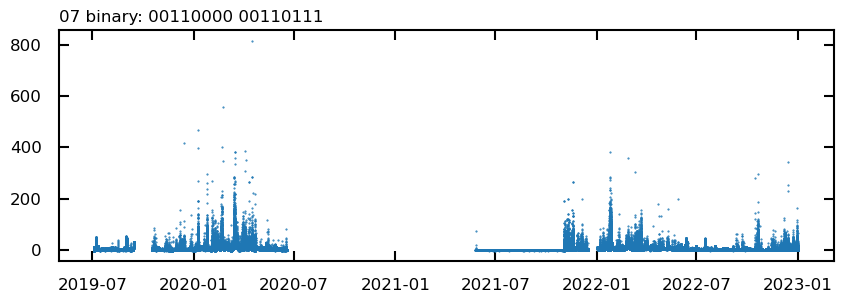

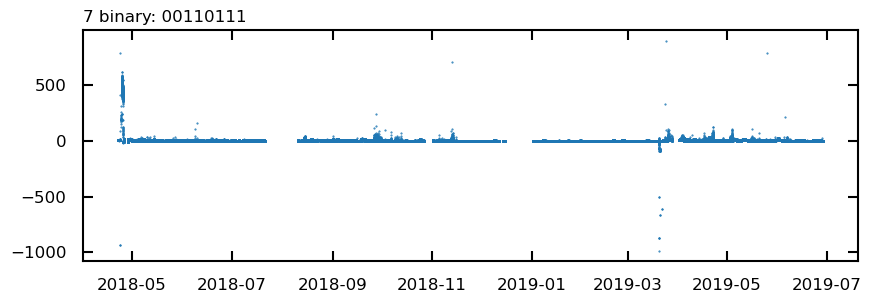

In [57]:
df_digital_flags_removed = keep_certain_flags(df_flags_removed, flag_var='F2_S13', given_flag_col='digital_flags',
                                              flags_allowed=['07','7'])
digital_flags_allowed = ['07','7']
for digitial_flag in digital_flags_allowed:
    plot_digital_flag(df_digital_flags_removed, digitial_flag, dict_flags_to_binary)   

In [58]:
def replace_9999_numeric(df):
    df = df.replace(9999.99, np.nan)
    cols = appended_ecotech_data.columns[5:]
    print(cols)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    return df

In [59]:
df_digital_flags_removed_cleaned = replace_9999_numeric(df_digital_flags_removed)

Index(['BsB_S13', 'BsG_S13', 'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13',
       'CcB_S13', 'CcG_S13', 'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13',
       'T_S13', 'U_S13', 'P_S13', 'BbswB_S13', 'BbswG_S13', 'BbswR_S13',
       'BswB_S13', 'BswG_S13', 'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13',
       'CbsR_S13', 'CfB_S13', 'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13',
       'CsR_S13', 'PCTbcB_S13', 'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13',
       'PCTcG_S13', 'PCTcR_S13', 'Pw_S13', 'Tw_S13', 'Tx_S13',
       'ZPARAMETERS_S13', 'ZSPANCHECK_S13', 'Cd_S13', 'ZEE_S13'],
      dtype='object')


In [60]:
def create_subplots(df, start_from, ncols):
    size = len(df.columns[start_from:])
    print(size)  
    nrows = size/ncols
    remainder = size%ncols
    fig, axs = plt.subplots(int(nrows+remainder),int(ncols), figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i, col in enumerate(df.columns[start_from:]):
        axs[i].plot(df.index, df[col].values, 'o', ms=1)
        axs[i].set_title(str(col))
    plt.show()
    return fig

46


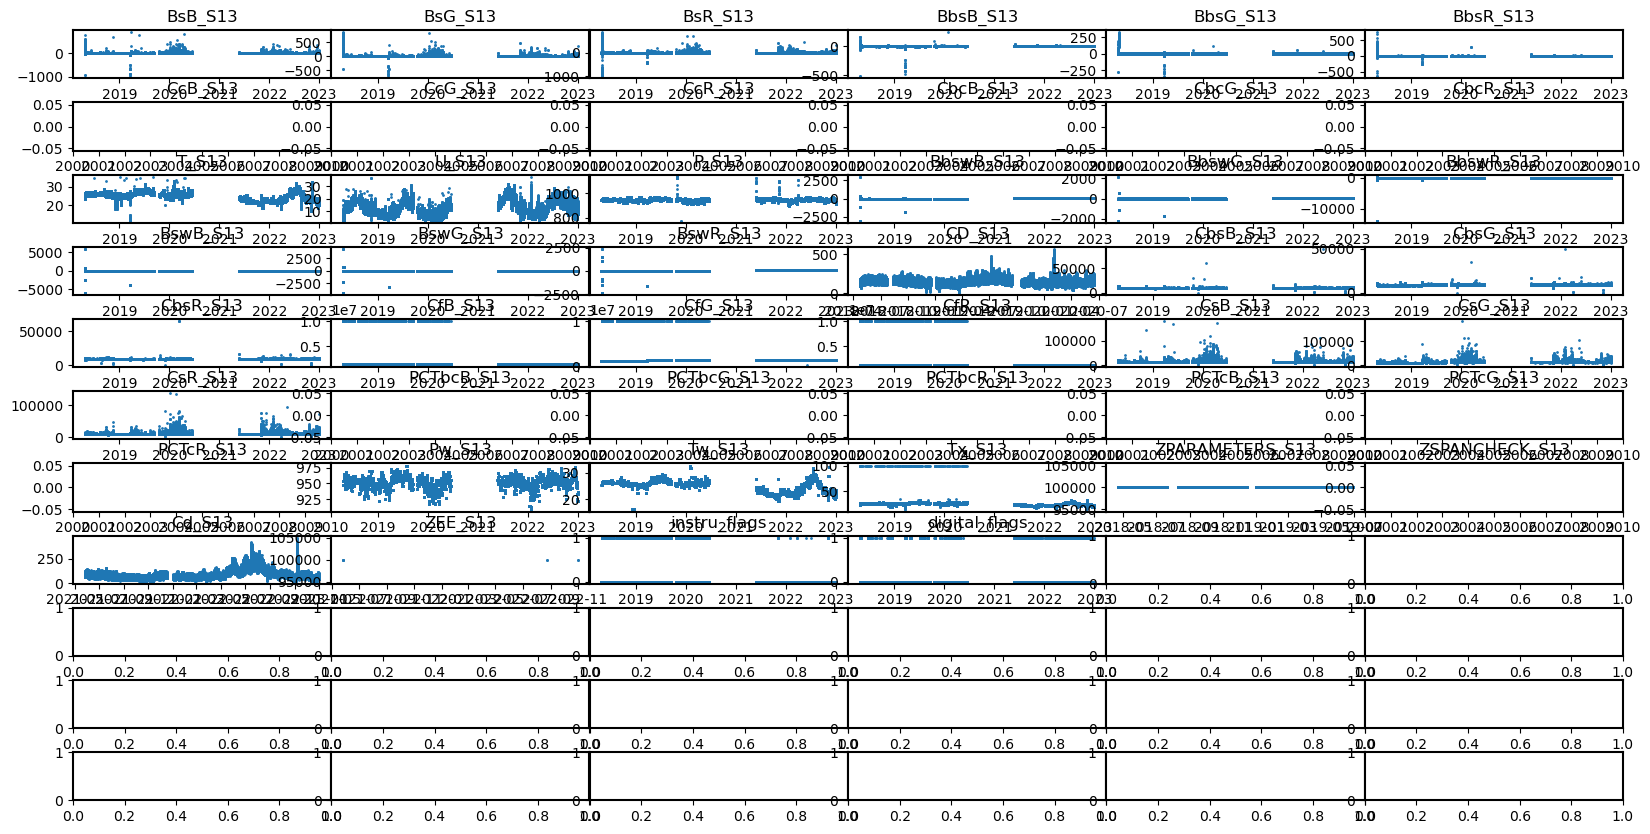

In [61]:
fig = create_subplots(df_digital_flags_removed_cleaned, start_from=5, ncols=6)

In [62]:
df_ecotech_data = df_digital_flags_removed_cleaned.copy()

In [63]:
df_ecotech_data.head(2)

,Datetime,EPOCH,DOY,F1_S13,F2_S13,BsB_S13,BsG_S13,BsR_S13,BbsB_S13,BbsG_S13,...,PCTcR_S13,Pw_S13,Tw_S13,Tx_S13,ZPARAMETERS_S13,ZSPANCHECK_S13,Cd_S13,ZEE_S13,instru_flags,digital_flags
DOY,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1
2018-04-22 14:10:02.784,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1


In [64]:
def rename_col(df_ecotech_data):
    df_ecotech_data_select_columns =  df_ecotech_data[['F1_S13','F2_S13','BsB_S13', 'BsG_S13','BsR_S13','BbsB_S13','BbsG_S13',
                                                   'BbsR_S13','T_S13','U_S13','P_S13']].copy()
    df_ecotech_data_select_columns = df_ecotech_data_select_columns.rename(columns={'F1_S13':'Instrument_flags','F2_S13':'Instrument_digital_state','BsB_S13':'scat450', 
                                    'BsG_S13':'scat525','BsR_S13':'scat635','BbsB_S13':'bscat450','BbsG_S13':'bscat525',
                                    'BbsR_S13':'bscat635','T_S13':'T_int','U_S13':'RH_int','P_S13':'p_int'})
    return df_ecotech_data_select_columns

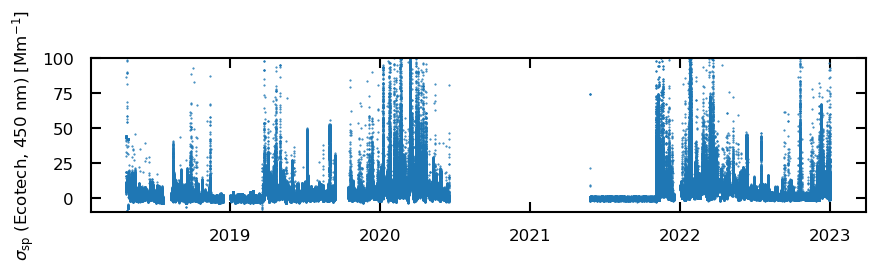

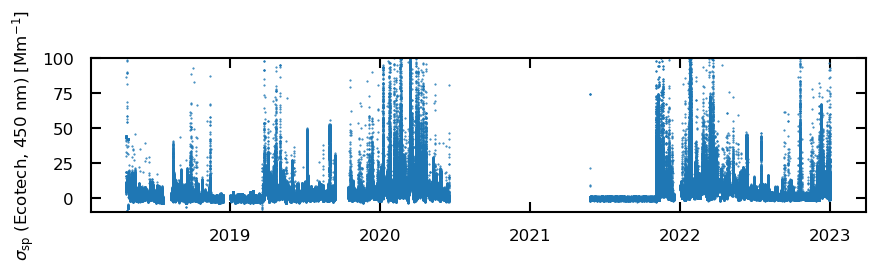

In [65]:
simple_plot(df_ecotech_data)

## add instrumental error: 

In [66]:
def deselect_periods(df):
    df.loc[:, 'instrument_error'] = 0
    #year == 2018:
    df.loc[('2018-11-13 00:00:00' <= df.index) & (df.index <= '2018-12-31 23:59:59'), ['instrument_error']] = 1 #for ectotech     
    #year == 2019:
    df.loc[('2019-01-01 00:00:00' <= df.index) & (df.index <= '2019-03-21 00:00:00'), ['instrument_error']] = 1 #for ecotech
    #year == 2021:
    df.loc[(df.index > '2021-05-01 00:00:00') & (df.index <='2021-11-01 00:00:00'), ['instrument_error']] = 1    
    print("percentage data points with instrument error :"+str(len(df[df['instrument_error'] == 1])*100/len(df)))    
    print("amount with instrument error: "+str(len(df[df['instrument_error'] == 1])/len(df)))
    return df

In [67]:
df_ecotech_data.head(2)

,Datetime,EPOCH,DOY,F1_S13,F2_S13,BsB_S13,BsG_S13,BsR_S13,BbsB_S13,BbsG_S13,...,PCTcR_S13,Pw_S13,Tw_S13,Tx_S13,ZPARAMETERS_S13,ZSPANCHECK_S13,Cd_S13,ZEE_S13,instru_flags,digital_flags
DOY,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1
2018-04-22 14:10:02.784,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1


In [68]:
df_ecotech_data = deselect_periods(df_ecotech_data)

percentage data points with instrument error :20.557067453829188
amount with instrument error: 0.20557067453829186


In [69]:
df_ecotech_data_noinstrumenterrors = df_ecotech_data[df_ecotech_data['instrument_error'] != 1]

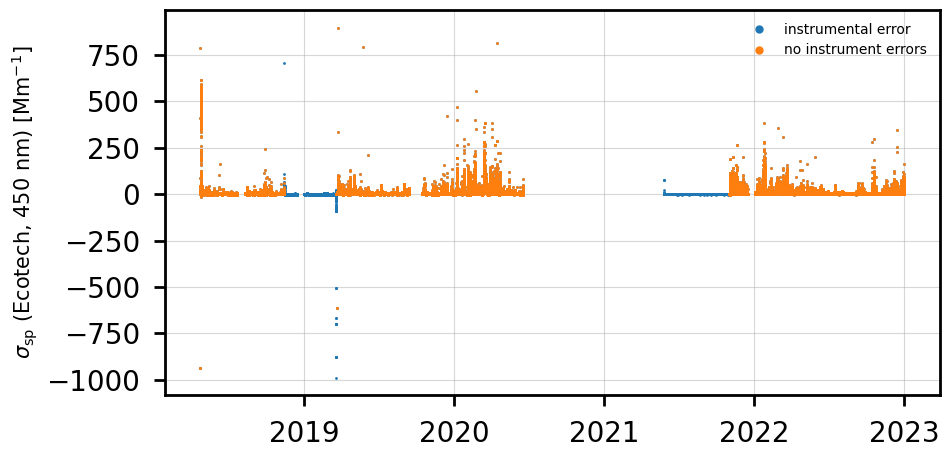

In [70]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_ecotech_data.index, df_ecotech_data['BsB_S13'], 'o', ms=1, label='instrumental error')
ax.plot(df_ecotech_data_noinstrumenterrors.index, df_ecotech_data_noinstrumenterrors['BsB_S13'], 'o', ms=1, 
        label='no instrument errors')

ax.set_ylabel(dict_abs_labels['BsB_S13'], fontsize=15)
fancy(ax) 
plt.legend(frameon=False, markerscale=5)

plt.show()

In [71]:
df_ecotech_data.columns

Index(['Datetime', 'EPOCH', 'DOY', 'F1_S13', 'F2_S13', 'BsB_S13', 'BsG_S13',
       'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13', 'CcB_S13', 'CcG_S13',
       'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13', 'T_S13', 'U_S13',
       'P_S13', 'BbswB_S13', 'BbswG_S13', 'BbswR_S13', 'BswB_S13', 'BswG_S13',
       'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13', 'CbsR_S13', 'CfB_S13',
       'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13', 'CsR_S13', 'PCTbcB_S13',
       'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13', 'PCTcG_S13', 'PCTcR_S13',
       'Pw_S13', 'Tw_S13', 'Tx_S13', 'ZPARAMETERS_S13', 'ZSPANCHECK_S13',
       'Cd_S13', 'ZEE_S13', 'instru_flags', 'digital_flags',
       'instrument_error'],
      dtype='object')

# Add DUMBO data: two months of .scn data: 

There was a problem with the ECOTECH Neph in 2020/2021, however the data gap should not be as big. For 2021 are data from May 2021 available (on the hard drive). And for Oct and Nov 2020 are data available however in a different format (on hard drive under ‘Dumbo’).
Are you in the office? I can give you the data till Dec 2022.


In [72]:
dict_abs_labels = {'BsB_S13':'$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(Ecotech_blue)+' nm) [Mm$^{-1}$]',
                   'BsB_S41':'$\sigma_{\mathrm{sp}}$ (TSI, '+str(TSI_blue)+' nm) [Mm$^{-1}$]',
                   'BsG_S13':'$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(Ecotech_green)+' nm) [Mm$^{-1}$]',
                   'BsG_S41':'$\sigma_{\mathrm{sp}}$ (TSI, '+str(TSI_green)+' nm) [Mm$^{-1}$]',
                   'BsR_S13':'$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(Ecotech_red)+' nm) [Mm$^{-1}$]',
                   'BsR_S41':'$\sigma_{\mathrm{sp}}$ (TSI, '+str(TSI_red)+' nm) [Mm$^{-1}$]',
                   'T_S13': 'Sample temperature (°C) (Ecotech)',
                   'U_S13':'Sample RH (%)  (Ecotech)',
                   'P_S13' : 'Sample pressure (hPa)  (Ecotech)',
                   'T_S41': 'Sample temperature (°C) (TSI)',
                   'U_S41':'Sample RH (%)  (TSI)',
                   'P_S41' : 'Sample pressure (hPa)  (TSI)',
                   'Uu_S41':'Sample RH (%)  (TSI)',
                   'BbsB_S13':'$\sigma_{\mathrm{bsp}}$ (Ecotech, '+str(Ecotech_blue)+' nm) [Mm$^{-1}$]',
                   'BbsG_S13':'$\sigma_{\mathrm{bsp}}$ (Ecotech, '+str(Ecotech_green)+' nm) [Mm$^{-1}$]', 
                   'BbsR_S13':'$\sigma_{\mathrm{bsp}}$ (Ecotech, '+str(Ecotech_red)+' nm) [Mm$^{-1}$]',
                   'BbsB_S41':'$\sigma_{\mathrm{bsp}}$ (TSI, '+str(TSI_blue)+' nm) [Mm$^{-1}$]', 
                   'BbsG_S41':'$\sigma_{\mathrm{bsp}}$ (TSI, '+str(TSI_green)+' nm) [Mm$^{-1}$]', 
                   'BbsR_S41':'$\sigma_{\mathrm{bsp}}$ (TSI, '+str(TSI_red)+' nm) [Mm$^{-1}$]'}

In [73]:
#'Major state' #'F2_S13'
#'DIO state' #'F2_S13'

def read_DUMBO_data(path):    
    list_of_files = glob.glob(path+'\\*.scn')
    names=['Date', '\tTime', '\tScat_635[Mm^-1]', '\tScat_525[Mm^-1]',
           '\tScat_450[Mm^-1]', '\tBScat_635[Mm^-1]', '\tBScat_525[Mm^-1]',
           '\tBScat_450[Mm^-1]', '\tSampleTemp[°C]', 'T_int2', '\tRH?',
           '\tPressure[mBar]', '\tMajor state[Unit]', '\tDIO state[Unit]']
    values = ['Date', 'Time', 'scat635','scat525','scat450','bscat635','bscat525', 
              'bscat450','T_int', 'T_unknown', 'P_int', 'Major state', 'DIO state']
    values = ['Date', 'Time', 'BsR_S13','BsG_S13','BsB_S13','BbsR_S13','BbsG_S13', 
              'BbsB_S13','T_S13', 'T_unknown', 'U_S13', 'P_S13', 'F1_S13', 'F2_S13']

    DFs = []
    for file in list_of_files:
        #print(file)
        df = pd.read_csv(str(file), sep=',', skiprows=1, header=None, names=names,
                        encoding = 'unicode_escape', index_col=False)
        #print(len(df.columns))
        DFs.append(df)

    df_all = pd.concat(DFs)
    df_all = df_all.rename(columns=dict(zip(names, values)))
    df_all['Time'] = df_all['Time'].apply(lambda x: x.replace("\t", ""))
    df_all['datetime'] = pd.to_datetime(df_all['Date'] +' '+ df_all['Time'])
    df_all = df_all.drop(columns=['Date', 'Time', 'T_unknown'])
    df_all = df_all.set_index(['datetime'])
    df_all.index.names = ['DOY']

    print(df_all.columns)
    return df_all

In [74]:
df_DUMBO = read_DUMBO_data(path = DUMBO_ecotech_path)

Index(['BsR_S13', 'BsG_S13', 'BsB_S13', 'BbsR_S13', 'BbsG_S13', 'BbsB_S13',
       'T_S13', 'U_S13', 'P_S13', 'F1_S13', 'F2_S13'],
      dtype='object')


In [75]:
data_dtypes = dict(df_DUMBO.dtypes)
print(data_dtypes)

{'BsR_S13': dtype('float64'), 'BsG_S13': dtype('float64'), 'BsB_S13': dtype('float64'), 'BbsR_S13': dtype('float64'), 'BbsG_S13': dtype('float64'), 'BbsB_S13': dtype('float64'), 'T_S13': dtype('float64'), 'U_S13': dtype('float64'), 'P_S13': dtype('float64'), 'F1_S13': dtype('int64'), 'F2_S13': dtype('int64')}


In [76]:
df_DUMBO.columns

Index(['BsR_S13', 'BsG_S13', 'BsB_S13', 'BbsR_S13', 'BbsG_S13', 'BbsB_S13',
       'T_S13', 'U_S13', 'P_S13', 'F1_S13', 'F2_S13'],
      dtype='object')

[0 6]
type: <class 'numpy.int64'>
[]
0    189650
6         9
Name: F1_S13, dtype: int64
[0 6]
[189650      9]


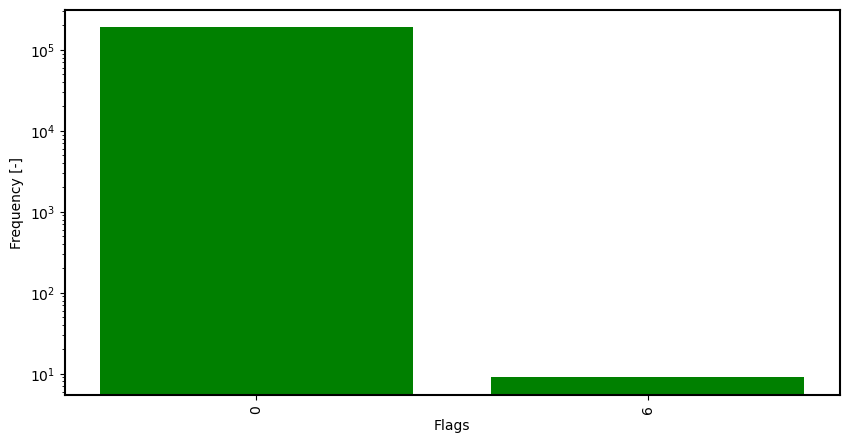

In [77]:
df_freq_instrument_flags = get_freq_flags(df_DUMBO)
fig = bar_plot(df_freq_instrument_flags, var='F1_S13')

   F2_S13
7  189642
3       9
4       8
[7 3 4]
[189642      9      8]


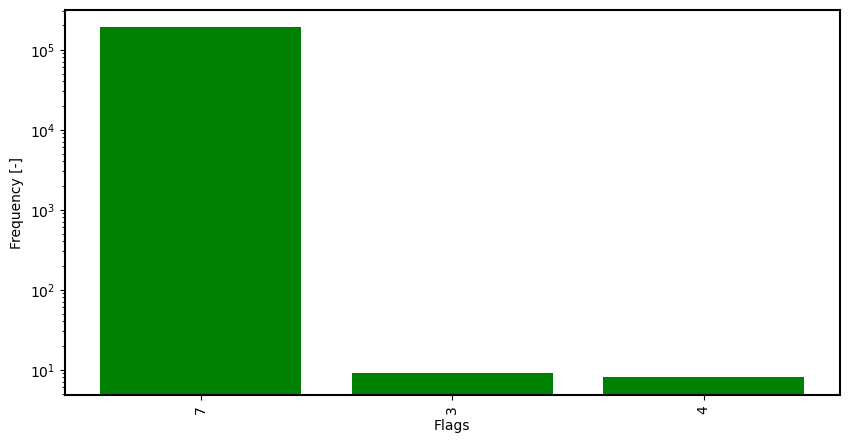

In [78]:
df_freq_Instrument_digital_state_flags = df_DUMBO['F2_S13'].value_counts().to_frame()
print(df_freq_Instrument_digital_state_flags)
fig = bar_plot(df_freq_Instrument_digital_state_flags, var='F2_S13')

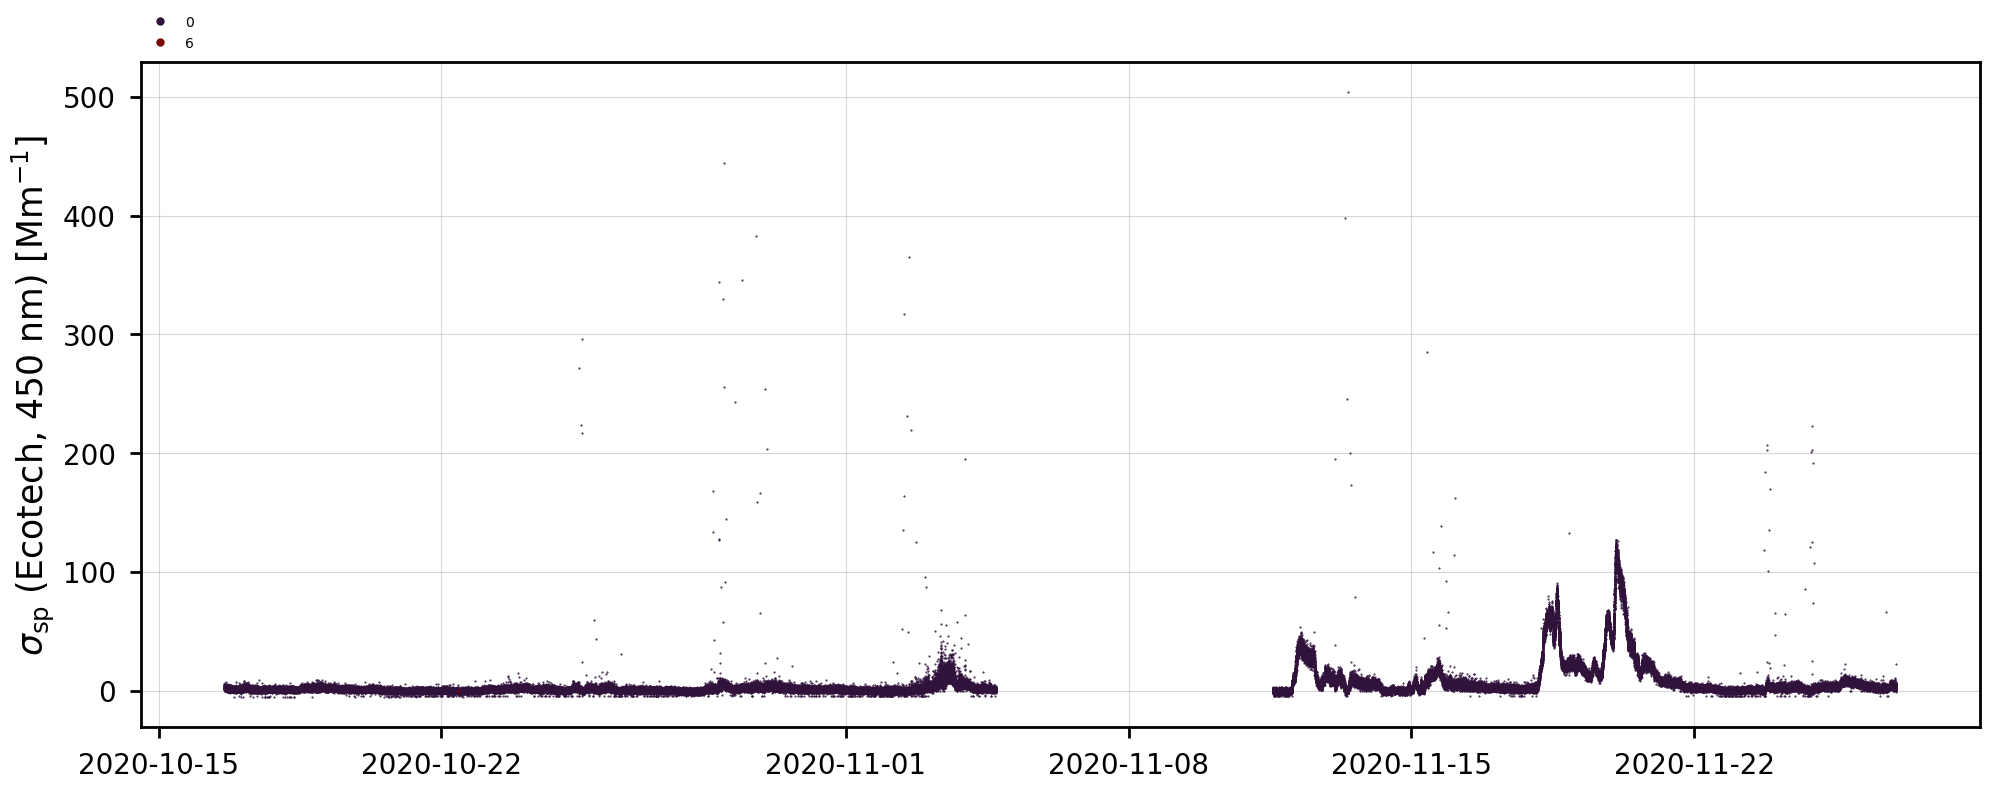

['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Data\\processed_data\\plots\\TSI_Ecotech\\']
make folder
saved as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Data\processed_data\plots\TSI_Ecotech\\\df_DUMBO_ecotech.jpeg


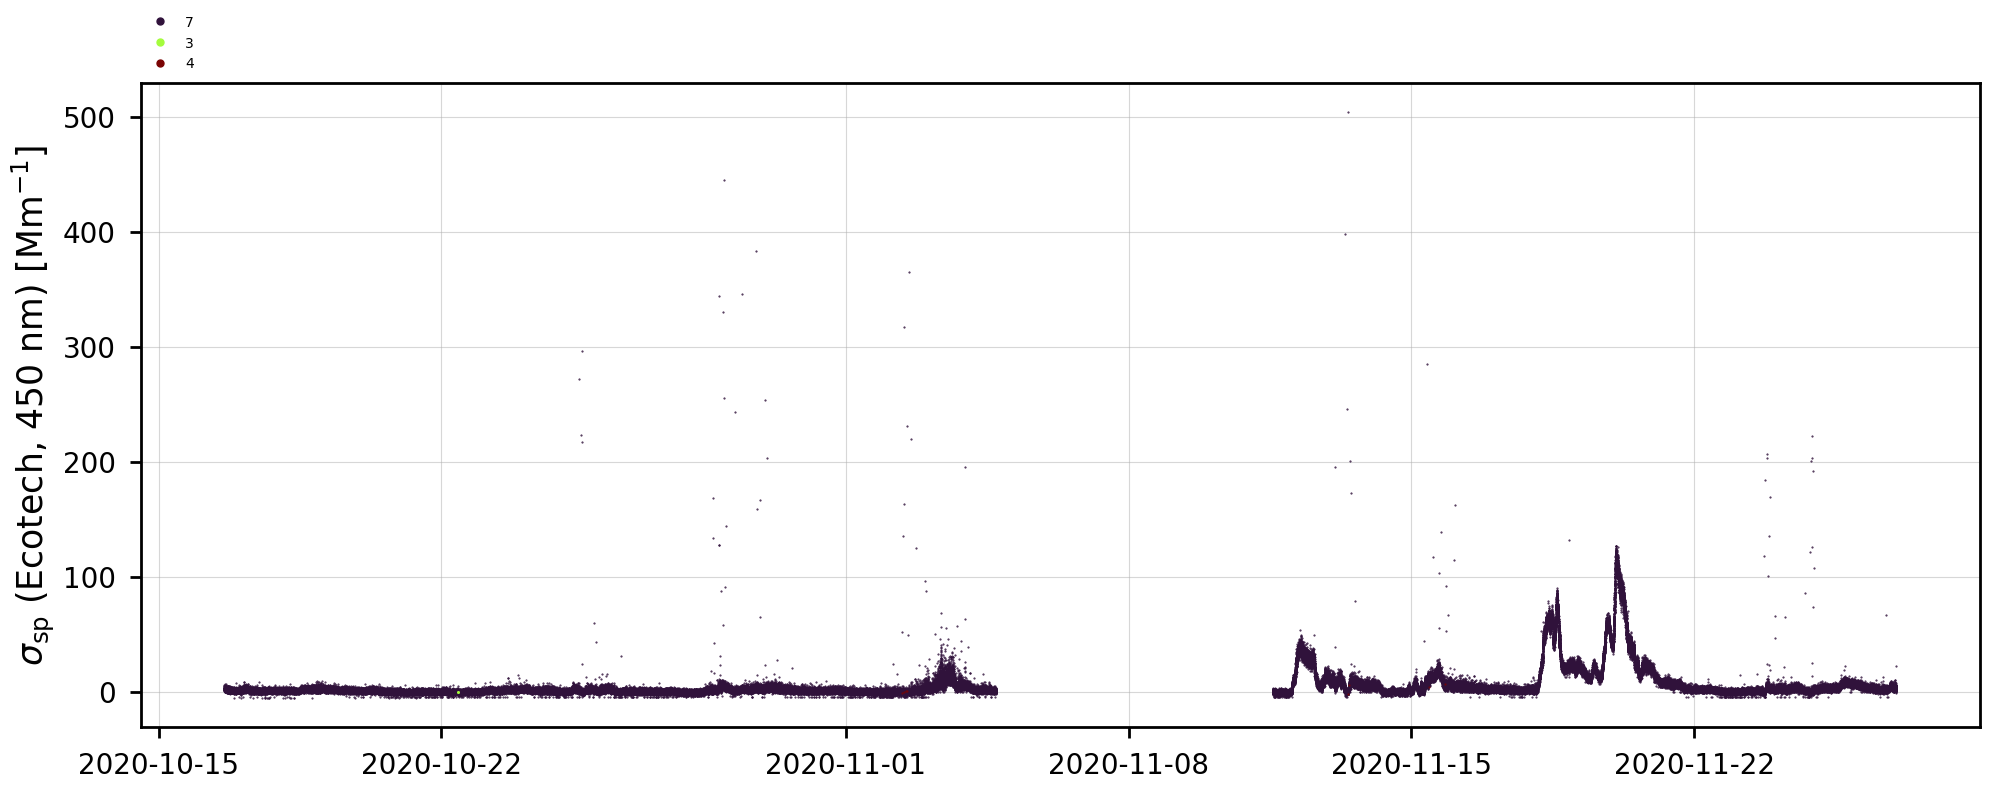

In [79]:
fig = simple_plot_instrument_flags(df_DUMBO, flag_var='F1_S13', legend_cols=2)
save_plot(fig, name='df_DUMBO_ecotech')
fig = simple_plot_instrument_flags(df_DUMBO, flag_var='F2_S13', legend_cols=2)

In [80]:
F1_S13s = df_DUMBO['F1_S13'].unique()
print(F1_S13s)
F2_S13s = df_DUMBO['F2_S13'].unique()
print(F2_S13s)

[0 6]
[7 3 4]


In [81]:
df_DUMBO = keep_certain_flags(df_DUMBO, flag_var='F1_S13',given_flag_col='instru_flags',
                                  flags_allowed=[0])
df_DUMBO = keep_certain_flags(df_DUMBO, flag_var='F2_S13',given_flag_col='digital_flags',
                                  flags_allowed=[7])
df_DUMBO.loc[:, 'instrument_error'] = 0

[0 6]
[0 6]
check remaining numflags: [0]
[0 1]
[7 3 4]
[7 3 4]
check remaining numflags: [0]
[0 1]


## convert to STP: 

In [82]:
def correct_standard_Temp_P(df, varlist, temp_var='T_int', press_var='p_int'):
    print("Correct for standard temperature and pressure")    
    mean_temp = df[temp_var].mean()
    print("Mean temperature: "+str(mean_temp)) 
    if mean_temp > 200: #kelvin
        print("in Kelvin")
        pass
    if mean_temp < 50:
        print("convert to Kelvin")
        df[temp_var] = df[temp_var]+273.15 #Kelvin        
    variables = [x for x in varlist if 'scat' in x]
    stand_temperature = 273.15
    stand_pressure = 1013.25
    for var in variables:
        df[str(var)] = df[var] * (df[p_int]*stand_temperature)/(df[temp_var]*stand_pressure)    
    df.loc[:,temp_var] -= 273.15   #to celcius
    return df

#df_ecotech_data_renamed = correct_standard_Temp_P(df_ecotech_data_renamed, varlist)

In [83]:
print(df_DUMBO.columns)
varlist = ['BsR_S13', 'BsG_S13', 'BsB_S13', 'BbsR_S13', 'BbsG_S13', 'BbsB_S13']
df_DUMBO = correct_standard_Temp_P(df_DUMBO, varlist, temp_var='T_S13', press_var='P_S13')

Index(['BsR_S13', 'BsG_S13', 'BsB_S13', 'BbsR_S13', 'BbsG_S13', 'BbsB_S13',
       'T_S13', 'U_S13', 'P_S13', 'F1_S13', 'F2_S13', 'instru_flags',
       'digital_flags', 'instrument_error'],
      dtype='object')
Correct for standard temperature and pressure
Mean temperature: 26.104067094091203
convert to Kelvin


## concat: 

In [84]:
df_DUMBO.head(2)

,BsR_S13,BsG_S13,BsB_S13,BbsR_S13,BbsG_S13,BbsB_S13,T_S13,U_S13,P_S13,F1_S13,F2_S13,instru_flags,digital_flags,instrument_error
DOY,,,,,,,,,,,,,,
2020-10-16 15:04:50,0.920,5.573,3.742,-2.113,0.560,0.354,25.356,8.297,962.730,0,7,0,0,0
2020-10-16 15:05:10,1.573,4.600,3.582,-1.181,1.444,4.888,25.356,8.297,962.696,0,7,0,0,0


In [85]:
df_concatted = pd.concat([df_ecotech_data_noinstrumenterrors, df_DUMBO])

In [86]:
df_concatted.head(2)

,Datetime,EPOCH,DOY,F1_S13,F2_S13,BsB_S13,BsG_S13,BsR_S13,BbsB_S13,BbsG_S13,...,Pw_S13,Tw_S13,Tx_S13,ZPARAMETERS_S13,ZSPANCHECK_S13,Cd_S13,ZEE_S13,instru_flags,digital_flags,instrument_error
DOY,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1,0
2018-04-22 14:10:02.784,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1,0


In [87]:
def simple_plot(df, var='scat450', max_value=800):
    fig, ax = plt.subplots(1, figsize=(12,3))
    print(df[var].max())
    ax.plot(df.index, df[var],'o',ms=0.5)
    ax.set_ylim(-10,max_value)
    thickax(ax)
    plt.show()
    return fig

1001.731


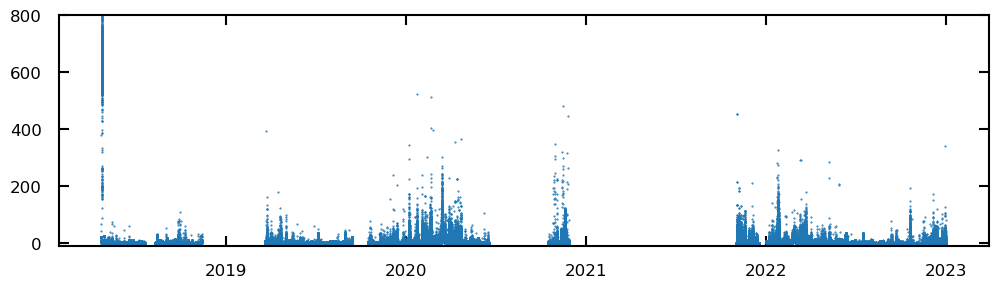

In [88]:
fig = simple_plot(df_concatted, var='BsG_S13')

7
1001.731
1001.731


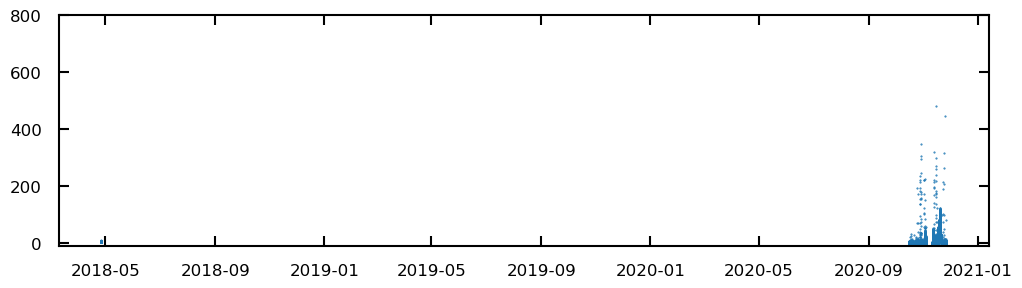

3
0.0
0.0


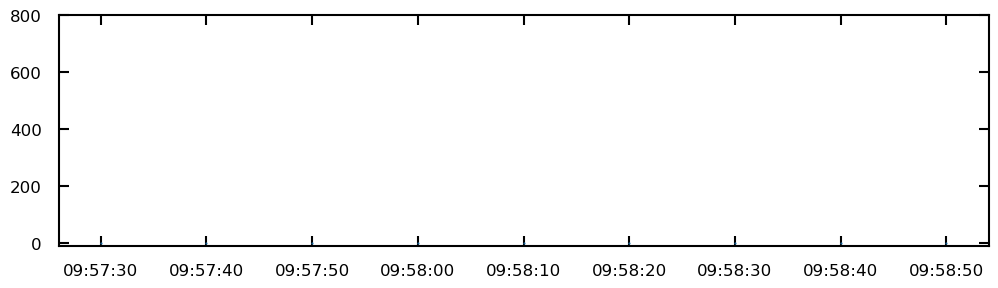

4
8.993
8.993


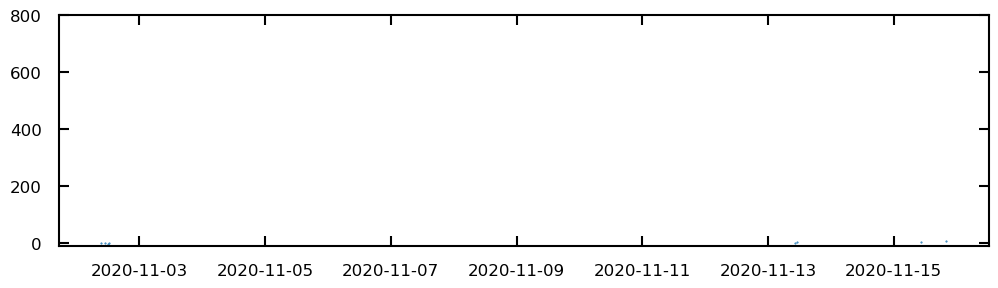

In [89]:
for flag in F2_S13s:
    print(flag)
    df_ = df_concatted[df_concatted['F2_S13'] == flag]
    print(df_['BsG_S13'].max())
    fig = simple_plot(df_, var='BsG_S13', max_value=800)

0
1001.731


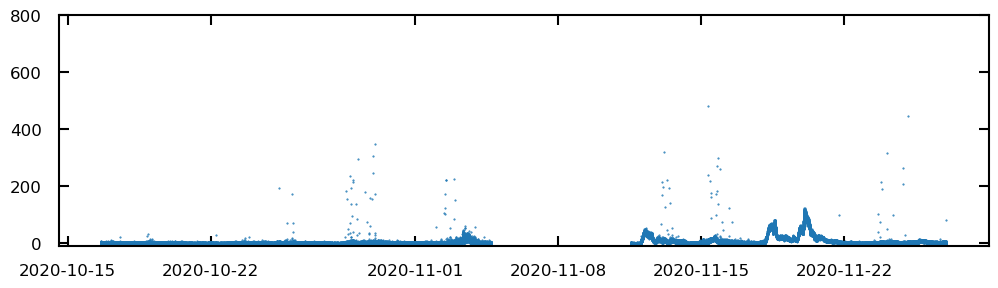

6
0.0


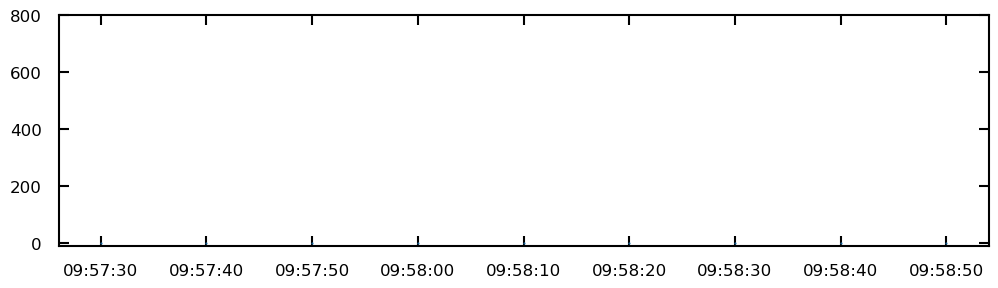

In [90]:
for flag in F1_S13s:
    print(flag)
    df_ = df_concatted[df_concatted['F1_S13'] == flag]
    fig = simple_plot(df_, var='BsG_S13', max_value=800)

# Rename: 

In [91]:
def generate_dict_of_variables(start_year=2018, end_year=2023):
    print("load dict for variables")
    dict_of_variables = {}    
    wavelengths = [450, 525, 635] #B, G, R
    correction_factors = [(1.455, -.189), (1.434, -0.176), (1.403, -.156)]
    cols_wavelengths = ['scat450', 'scat525', 'scat635']  
    detection_limits = [0.10, 0.13, 0.11, 0.09, 0.11, 0.12] #post averaging of five minute moving average
    varlist = ['scat450', 'scat525', 'scat635','bscat450','bscat525','bscat635', 'p_int', 'T_int', 'RH_int']
    years = np.arange(start_year,end_year+1,1)
    parse_dates=['DOY']
    index_col=['DOY']
    
    types_dict = {'EPOCH':'float64', 'F1_S13':'object', 'F2_S13':'object', 
           'BsB_S13':'float64', 'BsG_S13':'float64', 'BsR_S13':'float64', 'BbsB_S13':'float64', 'BbsG_S13':'float64',
           'BbsR_S13':'float64', 'CcB_S13':'float64', 'CcG_S13':'float64', 'CcR_S13':'float64', 'CbcB_S13':'float64', 
           'CbcG_S13':'float64', 'CbcR_S13':'float64', 'T_S13':'float64', 'U_S13':'float64', 'P_S13':'float64', 
           'BbswB_S13':'float64', 'BbswG_S13':'float64', 'BbswR_S13':'float64', 'BswB_S13':'float64', 'BswG_S13':'float64',
           'BswR_S13':'float64', 'CD_S13':'float64', 'CbsB_S13':'float64', 'CbsG_S13':'float64', 'CbsR_S13':'float64', 
           'CfB_S13':'float64', 'CfG_S13':'float64', 'CfR_S13':'float64', 'CsB_S13':'float64', 'CsG_S13':'float64', 
           'CsR_S13':'float64', 'PCTbcB_S13':'float64', 'PCTbcG_S13':'float64', 'PCTbcR_S13':'float64', 'PCTcB_S13':'float64',
           'PCTcG_S13':'float64', 'PCTcR_S13':'float64', 'Pw_S13':'float64', 'Tw_S13':'float64', 'Tx_S13':'float64', 
           'ZPARAMETERS_S13':'float64', 'ZSPANCHECK_S13':'float64'} #To import the files quicker a dictionary for the data types is created:
    
    flag_cols = ['digital_flags', 'instru_flags', 'instrument_error']
    dict_of_variables = {'wavelengths':wavelengths, 'correction_factors':correction_factors, 
                         'cols_wavelengths':cols_wavelengths, 'detection_limits':detection_limits, 
                         'varlist':varlist, 'years':years, 'parse_dates':parse_dates, 
                         'index_col':index_col, 'types_dict':types_dict, 'flag_cols':flag_cols}
    return dict_of_variables

In [92]:
def remove_duplicates(df, keep_duplicates_how='first'):
    print("Length before: "+str(len(df)))
    duplicateRowsDF = df.index[df.index.duplicated()]
    print("Duplicate Rows except first occurrence based on all columns are :"+str(len(duplicateRowsDF)))
    df = df.loc[~df.index.duplicated(keep=keep_duplicates_how)]
    print("Length after: "+str(len(df)))
    return df

def number_of_duplicates(df):
    print("Length before: "+str(len(df)))
    duplicateRowsDF = df.index[df.index.duplicated()]
    print("Number of duplicated indexes :")    
    print(len(duplicateRowsDF))

In [93]:
df_concatted = remove_duplicates(df_concatted) 
number_of_duplicates(df_concatted) 

Length before: 1637570
Duplicate Rows except first occurrence based on all columns are :43277
Length after: 1594293
Length before: 1594293
Number of duplicated indexes :
0


In [94]:
df_concatted = filter_rows_by_values(df_concatted, col=df_concatted.columns, values=9999.99)            
df_concatted = replace_9999_numeric(df_concatted)

Index(['BsB_S13', 'BsG_S13', 'BsR_S13', 'BbsB_S13', 'BbsG_S13', 'BbsR_S13',
       'CcB_S13', 'CcG_S13', 'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13',
       'T_S13', 'U_S13', 'P_S13', 'BbswB_S13', 'BbswG_S13', 'BbswR_S13',
       'BswB_S13', 'BswG_S13', 'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13',
       'CbsR_S13', 'CfB_S13', 'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13',
       'CsR_S13', 'PCTbcB_S13', 'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13',
       'PCTcG_S13', 'PCTcR_S13', 'Pw_S13', 'Tw_S13', 'Tx_S13',
       'ZPARAMETERS_S13', 'ZSPANCHECK_S13', 'Cd_S13', 'ZEE_S13'],
      dtype='object')


In [95]:
def rename_ecotech_data(df):
    df = df.rename(columns={'F1_S13':'numflag', 'F2_S13':'Code', 'BsB_S13':'scat450', 'BsG_S13':'scat525',
                            'BsR_S13':'scat635','BbsB_S13':'bscat450','BbsG_S13':'bscat525', 'BbsR_S13':'bscat635',
                            'T_S13':'T_int','U_S13':'RH_int','P_S13':'p_int'})
        
    df = df.drop(columns=['Datetime', 'DOY', 'EPOCH', 'CcB_S13', 'CcG_S13',
       'CcR_S13', 'CbcB_S13', 'CbcG_S13', 'CbcR_S13', 'BbswB_S13', 
       'BbswG_S13', 'BbswR_S13', 'BswB_S13', 'BswG_S13',
       'BswR_S13', 'CD_S13', 'CbsB_S13', 'CbsG_S13', 'CbsR_S13', 'CfB_S13',
       'CfG_S13', 'CfR_S13', 'CsB_S13', 'CsG_S13', 'CsR_S13', 'PCTbcB_S13',
       'PCTbcG_S13', 'PCTbcR_S13', 'PCTcB_S13', 'PCTcG_S13', 'PCTcR_S13',
       'Pw_S13', 'Tw_S13', 'Tx_S13', 'ZPARAMETERS_S13', 'ZSPANCHECK_S13'])
        
    #rename index to date
    df.index.names = ['datetime'] #change name of index
    df.loc[:,'Flag'] = 0 #not used
    return df

In [96]:
df_concatted.head(2)

,Datetime,EPOCH,DOY,F1_S13,F2_S13,BsB_S13,BsG_S13,BsR_S13,BbsB_S13,BbsG_S13,...,Pw_S13,Tw_S13,Tx_S13,ZPARAMETERS_S13,ZSPANCHECK_S13,Cd_S13,ZEE_S13,instru_flags,digital_flags,instrument_error
DOY,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1,0
2018-04-22 14:10:02.784,2018-04-21 14:10:00,1.524320e+09,2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,...,NaN,NaN,25.8,99999.999,NaN,NaN,NaN,0,1,0


In [97]:
df_ecotech_data_renamed = rename_ecotech_data(df_concatted) 

In [98]:
df_ecotech_data_renamed.head(2)

,numflag,Code,scat450,scat525,scat635,bscat450,bscat525,bscat635,T_int,RH_int,p_int,Cd_S13,ZEE_S13,instru_flags,digital_flags,instrument_error,Flag
datetime,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,0.98,24.7,10.8,945.1,NaN,NaN,0,1,0,0
2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,0.98,24.7,10.8,945.1,NaN,NaN,0,1,0,0


In [99]:
dict_of_variables = generate_dict_of_variables()
varlist = dict_of_variables['varlist']
#do not correct for STP
#df_ecotech_data_renamed = correct_standard_Temp_P(df_ecotech_data_renamed, varlist)

load dict for variables


In [100]:
df_ecotech_data_renamed.head(2)

,numflag,Code,scat450,scat525,scat635,bscat450,bscat525,bscat635,T_int,RH_int,p_int,Cd_S13,ZEE_S13,instru_flags,digital_flags,instrument_error,Flag
datetime,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,0.98,24.7,10.8,945.1,NaN,NaN,0,1,0,0
2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,0.98,24.7,10.8,945.1,NaN,NaN,0,1,0,0


In [101]:
def simple_plot_hourly(df, var='scat450', max_value=100):
    fig, ax = plt.subplots(1, figsize=(20,8))
    ax.plot(df.index, df[var],'o', ms=0.5, c='k', label=str(var))       
    ax.set_ylabel(dict_abs_labels['BsB_S13'], fontsize=25)
    fancy(ax) 
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01),
            borderaxespad=0, frameon=False, markerscale=10,)
    ax.set_ylim(0, max_value)
    plt.tight_layout()
    plt.show()
    return fig

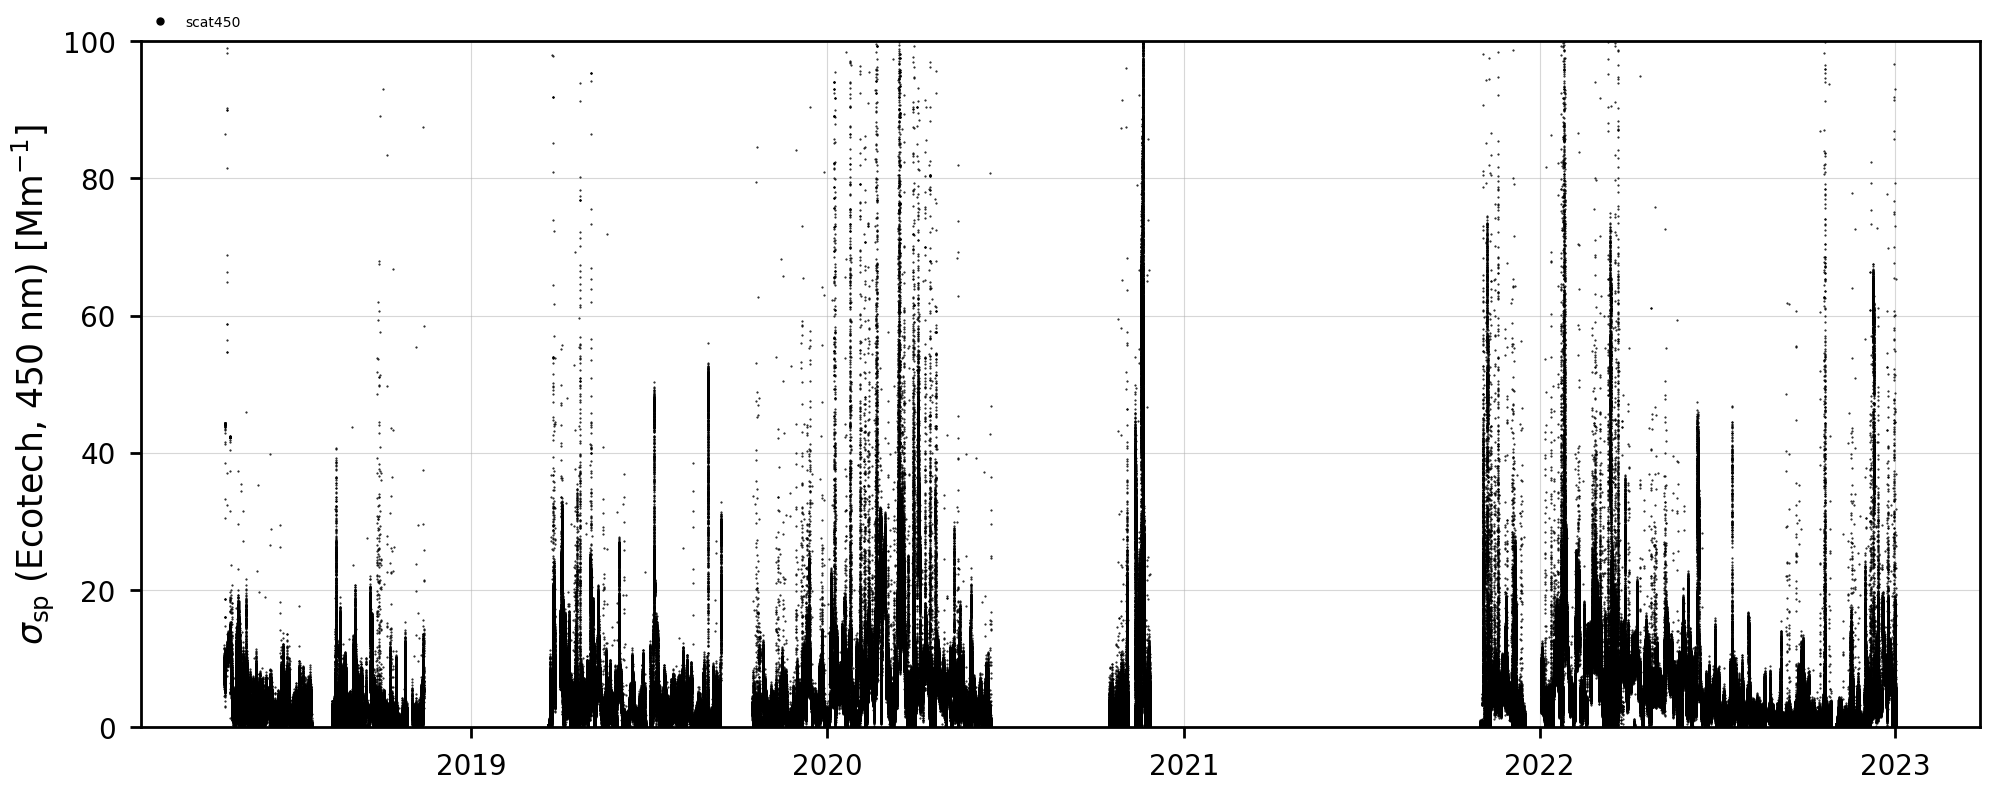

In [102]:
fig = simple_plot_hourly(df_ecotech_data_renamed, var='scat450', max_value=100)

In [103]:
def calculate_AE(df, wavelengths, correction_factors, cols_wavelengths, colour1, colour2, AE_name, bscat=''):
    print("wavelengths: "+str(wavelengths))
    colour_to_wavelength = {'blue':wavelengths[0], 'green':wavelengths[1], 'red':wavelengths[2]}
    colour_to_CF = {'blue':correction_factors[0], 'green':correction_factors[1], 'red':correction_factors[2]}
    colour_to_col = {'blue':cols_wavelengths[0], 'green':cols_wavelengths[1], 'red':cols_wavelengths[2]}
        
    col1 = colour_to_col[colour1] 
    col2 = colour_to_col[colour2] 
    wavelength1 = colour_to_wavelength[colour1]
    wavelength2 = colour_to_wavelength[colour2]
    
    #−ln(σsp1/σsp2)/ln(λ1/λ2) 
    AE = -(( np.log( df[col1]/df[col2]) ) / ( np.log(wavelength1/wavelength2) ) )
    #AE = -(np.log10(np.where(df[col1]/df[col2]>0.0, df[col1]/df[col2], 1e-300))/np.log10(np.where(wavelength1/wavelength2>0.0, wavelength1/wavelength2, 1e-300)))
    
    df[str(bscat)+'AE_'+str(colour_to_wavelength[AE_name])] = AE
    return df
    
#Correction factor for Angular Nonidealities 
def correct_scattering(df, colour_to_CF, colour_to_wavelength, colour_to_col, colour):
    CF = float(colour_to_CF[colour][0]) + float(colour_to_CF[colour][1])*df['AE_'+str(colour_to_wavelength[colour])]
    df['C_'+str(colour_to_wavelength[colour])] = CF
    df.loc[df['C_'+str(colour_to_wavelength[colour])] < 1, ['C_'+str(colour_to_wavelength[colour])]] = 1.0
    col = colour_to_col[colour] 
    df['CF_'+str(col)] = df[str(col)]*df['C_'+str(colour_to_wavelength[colour])]
    df = df.drop(columns=[str(col)])
    #df = df.drop(columns=['C_'+str(colour_to_wavelength[colour]), str(col)]) #drop correction factors and old scat col
    df = df.rename(columns={'CF_'+str(col): str(col)})
    return df
    
def calculate_apply_correction_factors(df, wavelengths, correction_factors, cols_wavelengths):   
    df = df.copy()
    print("wavelengths: "+str(wavelengths))
    print("correction_factors: "+str(correction_factors))
    print("cols_wavelengths: "+str(cols_wavelengths))
    
    colour_to_wavelength = {'blue':wavelengths[0], 'green':wavelengths[1], 'red':wavelengths[2]}
    colour_to_CF = {'blue':correction_factors[0], 'green':correction_factors[1], 'red':correction_factors[2]}
    colour_to_col = {'blue':cols_wavelengths[0], 'green':cols_wavelengths[1], 'red':cols_wavelengths[2]}
      
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths, colour1='blue', colour2='green', AE_name='blue', 
                      bscat='') #Angstrom Exponent at 450nm
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths, colour1='blue', colour2='red', AE_name='green', 
                      bscat='')   #Angstrom Exponent at 550nm
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths, colour1='green', colour2='red', AE_name='red', 
                      bscat='')  #Angstrom Exponent at 700nm
       
    df = correct_scattering(df, colour_to_CF, colour_to_wavelength, colour_to_col, colour='blue')
    df = correct_scattering(df, colour_to_CF, colour_to_wavelength, colour_to_col, colour='green')
    df = correct_scattering(df, colour_to_CF, colour_to_wavelength, colour_to_col, colour='red')
    
    df = df.drop(columns=['AE_'+str(colour_to_wavelength['blue']), 'AE_'+str(colour_to_wavelength['green']),
                          'AE_'+str(colour_to_wavelength['red'])])
    return df
    
def apply_detection_limits(df, varlist, detection_limits): #all values under the following detection limits equal to zero
    print("for ecotech a rolling mean of 5 mins is applied:")
    df = df.rolling('5min').mean() #mean
    print("Detection limits: "+str(detection_limits))
    print("on the variables: "+str(varlist))
    print("after resampling mark with a 1")
    for i in np.arange(0, 6, 1):
        df['detection_limit_'+varlist[i]] = 0
        df.loc[(df[varlist[i]] < detection_limits[0]), ['detection_limit_'+varlist[i]]] = 1 #add detection limit flag
    return df
    
def hourly_average_calculate_valid_count_index(df, minimum_value):
    print("Length of the original dataset: "+str(len(df)))
    count = df.resample('H').count() #count values per hour
    length = len(count) #size of dataframe
    print("Length of the original dataset in hours: "+str(length))
    invalid_hourly_index = count[count < minimum_value].dropna(how='all').index #index for hours containing lessthan minimum
    print("Number of invalid hourly points: "+str(len(invalid_hourly_index)))
    return invalid_hourly_index, length
    
def rename_columns(df):
    columns = df.columns
    column_names = [x+'_count' for x in columns]
    df.columns = column_names
    return df
    
def hourly_count(df, varlist):
    df_count = df.resample('H').agg({varlist[0]:'count', varlist[1]:'count', varlist[2]:'count',
                           varlist[3]:'count', varlist[4]:'count', varlist[5]:'count'}) 
    df_count = rename_columns(df_count) #rename columns
    return df_count
    
def hourly_average_select_valid_entries_based_on_count(df, varlist, flag_cols, invalid_daily_index, 
                                                      mean_or_median, detection_limits):
    print("average: "+str(mean_or_median))
    print("detection limits: "+str(detection_limits))
    #mark the hours which are affected by detection limits
    if detection_limits == True:    
        df = df.resample('H').agg({varlist[0]:mean_or_median, varlist[1]:mean_or_median, varlist[2]:mean_or_median,
                                   varlist[3]:mean_or_median, varlist[4]:mean_or_median, varlist[5]:mean_or_median,
                                   varlist[6]:mean_or_median, varlist[7]:mean_or_median, varlist[8]:mean_or_median,
                                   flag_cols[0]:'max', flag_cols[1]:'max', flag_cols[2]:'max',
                                  'detection_limit_'+varlist[0]:'max', 'detection_limit_'+varlist[1]:'max',
                                  'detection_limit_'+varlist[2]:'max','detection_limit_'+varlist[3]:'max',
                                  'detection_limit_'+varlist[4]:'max','detection_limit_'+varlist[5]:'max'})  # #hourly medians
    if detection_limits == False:
        df = df.resample('H').agg({varlist[0]:mean_or_median, varlist[1]:mean_or_median, varlist[2]:mean_or_median,
                                   varlist[3]:mean_or_median, varlist[4]:mean_or_median, varlist[5]:mean_or_median,
                                   varlist[6]:mean_or_median, varlist[7]:mean_or_median, varlist[8]:mean_or_median,
                                   flag_cols[0]:'max', flag_cols[1]:'max', flag_cols[2]:'max'})  # #hourly medians
    return df
    
def remove_np_nan_and_inf(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True) #cant cluster with np.nan
    df = df.dropna(how='any', axis=0)
    return df
    
def multiple_count(df, varlist, minimum_value):
    print("Required number of clean data points to perform hourly average: "+str(minimum_value))
    for var in varlist[:6]:     
        df[var] = np.where(df[var+'_count'] < minimum_value, np.nan, df[var]) #make values np.nan if below count
    return df
    
def hourly_resample(df_raw, df, varlist, flag_cols, detection_limits, mean_or_median):
    print("hourly resampling: ")
    
    invalid_hourly_index, length = hourly_average_calculate_valid_count_index(df_raw, minimum_value=4)

    df_count = hourly_count(df_raw, varlist) #produces a count df where elements are 1 if count greater than min
    count_cols = df_count.columns      
    
    df_hourly = hourly_average_select_valid_entries_based_on_count(df, varlist, flag_cols, invalid_hourly_index, 
                                                                   mean_or_median, detection_limits)   

    df_hourly = remove_duplicates(df_hourly)
    df_merged = pd.merge(df_hourly, df_count, how='left', left_index=True, right_index=True)
    #remove_duplicates(df_count)

    df_count_applied = multiple_count(df_merged, varlist, minimum_value=4) # 1 and 0 so remove points with 
    df_count_applied = df_count_applied.dropna(how='all')        
    df_merged = df_merged.dropna(how='all')       
    for var in varlist[:6]:     
        print("minimum count:")
        print(df_merged[var+'_count'].min())
    df_count_notapplied = df_merged.copy()
    return df_count_applied, df_count_notapplied
    
##map any flagged data to np.nan so hurly medians can be calculated for clean data before     
def values_below_LOD_nan(df, varlist):
    print("mark values below the detection limits as np.nan")
    for i in np.arange(0, 6, 1):
        df.loc[df['detection_limit_'+varlist[i]] == 1, [varlist[i]]] = np.nan #plays no part in the hourly averages 
    return df

In [104]:
df_ecotech_data_renamed.head(2)

,numflag,Code,scat450,scat525,scat635,bscat450,bscat525,bscat635,T_int,RH_int,p_int,Cd_S13,ZEE_S13,instru_flags,digital_flags,instrument_error,Flag
datetime,,,,,,,,,,,,,,,,,
2018-04-22 14:10:00.192,200,FF,7.52,6.31,6.03,1.17,1.0,0.98,24.7,10.8,945.1,NaN,NaN,0,1,0,0
2018-04-22 14:10:02.784,200,FF,7.52,6.31,6.03,1.17,1.0,0.98,24.7,10.8,945.1,NaN,NaN,0,1,0,0


# Make correction: 

In [105]:
df_ecotech_data_renamed['instru_flags'].value_counts()

0    1592775
1       1518
Name: instru_flags, dtype: int64

In [106]:
print(df_ecotech_data_renamed['instrument_error'].value_counts())
print(df_ecotech_data_renamed['instru_flags'].value_counts())
print(df_ecotech_data_renamed['digital_flags'].value_counts())

0    1594293
Name: instrument_error, dtype: int64
0    1592775
1       1518
Name: instru_flags, dtype: int64
0    1592316
1       1977
Name: digital_flags, dtype: int64


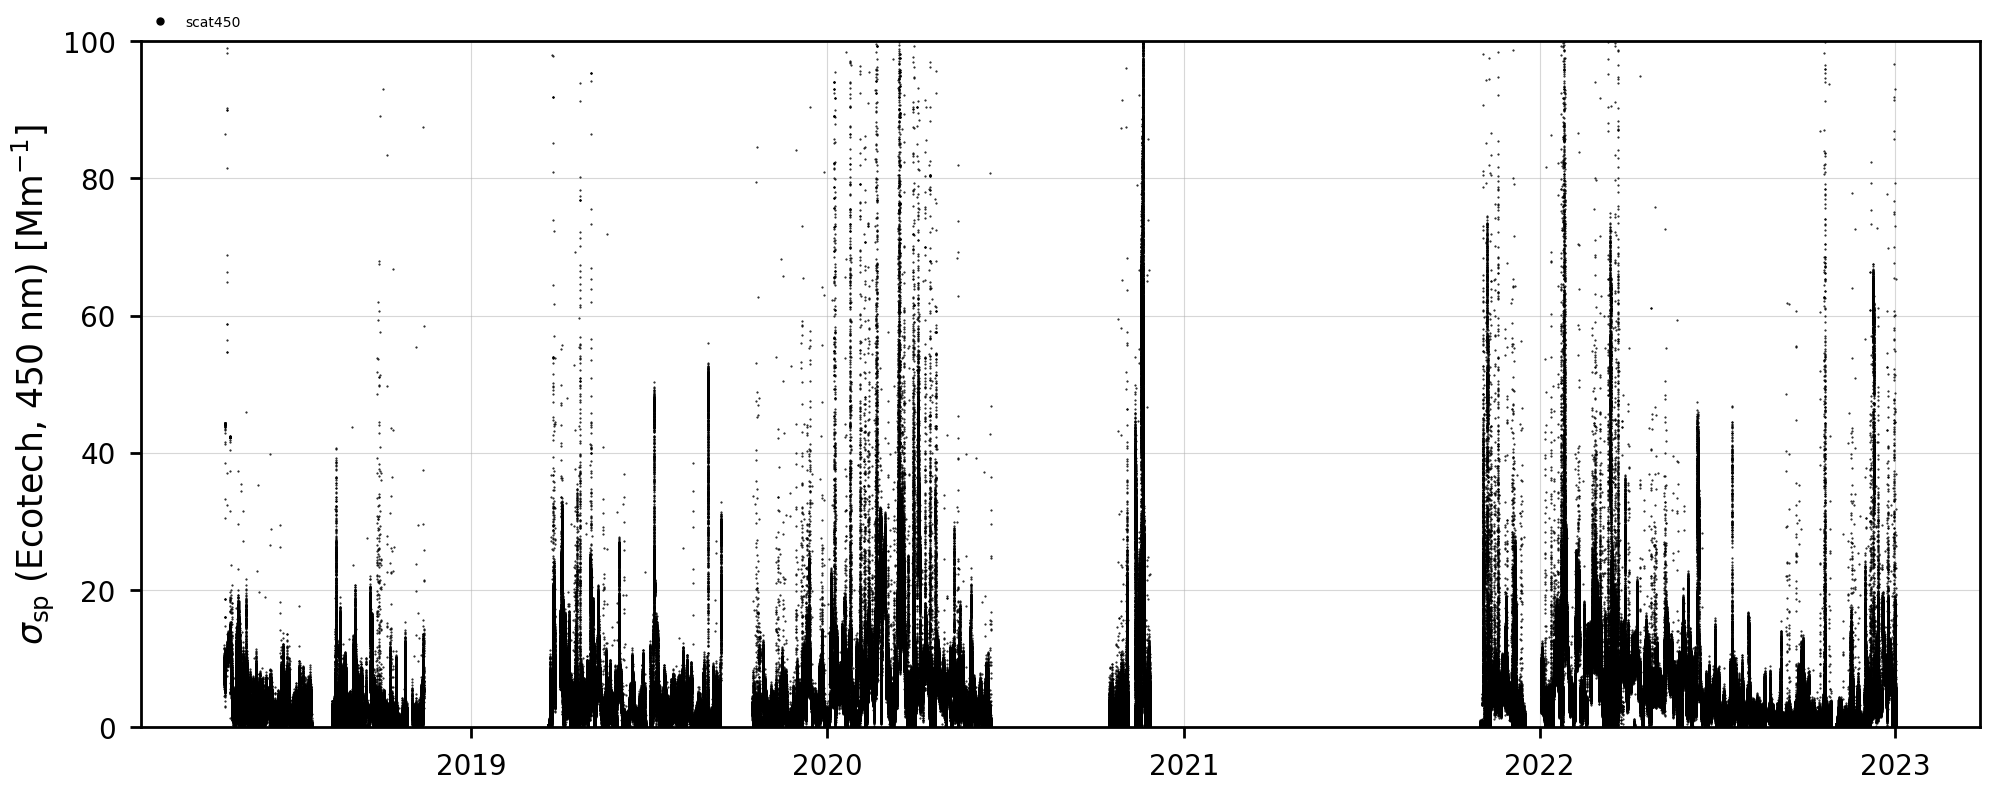

In [107]:
fig = simple_plot_hourly(df_ecotech_data_renamed, var='scat450', max_value=100)

In [108]:
mean_or_median = 'mean'

years = dict_of_variables['years']        
varlist = dict_of_variables['varlist'] 
types_dict = dict_of_variables['types_dict']        
wavelengths = dict_of_variables['wavelengths'] 
correction_factors = dict_of_variables['correction_factors'] 
cols_wavelengths = dict_of_variables['cols_wavelengths'] 
detection_limits = dict_of_variables['detection_limits']
flag_cols = dict_of_variables['flag_cols'] 
                
#Correction factor
df_CF = calculate_apply_correction_factors(df_ecotech_data_renamed, wavelengths, correction_factors, cols_wavelengths)

df_flags = df_CF[(df_CF['instru_flags'] == 1) | (df_CF['digital_flags'] == 1) | (df_CF['instrument_error'] == 1)] 
print("Lenght of flagged data: "+str(len(df_flags)))
print("df_flags example: ")
print(df_flags.head(2))

df_clean = df_CF[(df_CF['instru_flags'] == 0) & (df_CF['digital_flags'] == 0) & (df_CF['instrument_error'] == 0)]
print("Lenght of unflagged data: "+str(len(df_clean)))

#detection limits for each wavelength - flag them
df_clean = df_clean.sort_index()
df_LOD = apply_detection_limits(df_clean, varlist, detection_limits) #5mins

df_clean_LOD_not_applied = df_LOD.copy() 
df_clean_LOD_applied = values_below_LOD_nan(df_LOD, varlist) #make np.nan

df_flagged_hourly, df_flagged_hourly_countnotapplied = hourly_resample(df_clean, df_flags, varlist, 
                                                                       flag_cols, detection_limits=False,  
                                                                       mean_or_median=mean_or_median)
print("df_flagged hourly size: "+str(len(df_flagged_hourly)))
print("df_flagged hourly count not applied size: "+str(len(df_flagged_hourly_countnotapplied)))

df_cleaned_LOD_not_applied_hourly, df_cleaned_LOD_not_applied_hourly_countnotapplied = hourly_resample(df_clean, 
                                                                                                       df_clean_LOD_not_applied, 
                                                                                                       varlist, flag_cols,
                                                                                                       detection_limits=True, 
                                                                                                       mean_or_median=mean_or_median) #the values below LOD are removed    
df_cleaned_LOD_applied_hourly, df_cleaned_LOD_applied_hourly_countnotapplied = hourly_resample(df_clean, 
                                                                                               df_clean_LOD_applied,
                                                                                               varlist, flag_cols,
                                                                                               detection_limits=True, 
                                                                                               mean_or_median=mean_or_median) #the values below LOD are removed

print('\n')
df_cleaned_LOD_not_applied_hourly = remove_duplicates(df_cleaned_LOD_not_applied_hourly)

years_label = str(years[0])+'_'+str(years[-1])

#save files
df_cleaned_LOD_applied_hourly.to_csv(outpath_files+"hourly_clean\\"+str(years_label)+"_LOD.dat",index=True)
df_cleaned_LOD_not_applied_hourly.to_csv(outpath_files+"hourly_clean\\"+str(years_label)+"_noLOD.dat",index=True)
df_flagged_hourly.to_csv(outpath_files+"hourly_clean\\"+str(years_label)+"_flagged.dat",index=True)

df_cleaned_LOD_applied_hourly_countnotapplied.to_csv(outpath_files+"hourly_clean\\"+str(years_label)+"_LOD_countnotapplied.dat",index=True)
df_cleaned_LOD_not_applied_hourly_countnotapplied.to_csv(outpath_files+"hourly_clean\\"+str(years_label)+"_noLOD_countnotapplied.dat",index=True)
df_flagged_hourly_countnotapplied.to_csv(outpath_files+"hourly_clean\\"+str(years_label)+"_flagged_countnotapplied.dat",index=True)

wavelengths: [450, 525, 635]
correction_factors: [(1.455, -0.189), (1.434, -0.176), (1.403, -0.156)]
cols_wavelengths: ['scat450', 'scat525', 'scat635']
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]


C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Lenght of flagged data: 3476
df_flags example: 
                        numflag Code  bscat450  bscat525  bscat635  T_int  \
datetime                                                                    
2018-04-22 14:10:00.192     200   FF      1.17       1.0      0.98   24.7   
2018-04-22 14:10:02.784     200   FF      1.17       1.0      0.98   24.7   

                         RH_int  p_int  Cd_S13  ZEE_S13  instru_flags  \
datetime                                                                
2018-04-22 14:10:00.192    10.8  945.1     NaN      NaN             0   
2018-04-22 14:10:02.784    10.8  945.1     NaN      NaN             0   

                         digital_flags  instrument_error  Flag     C_450  \
datetime                                                                   
2018-04-22 14:10:00.192              1                 0     0  1.239909   
2018-04-22 14:10:02.784              1                 0     0  1.239909   

                          scat450     C_525  

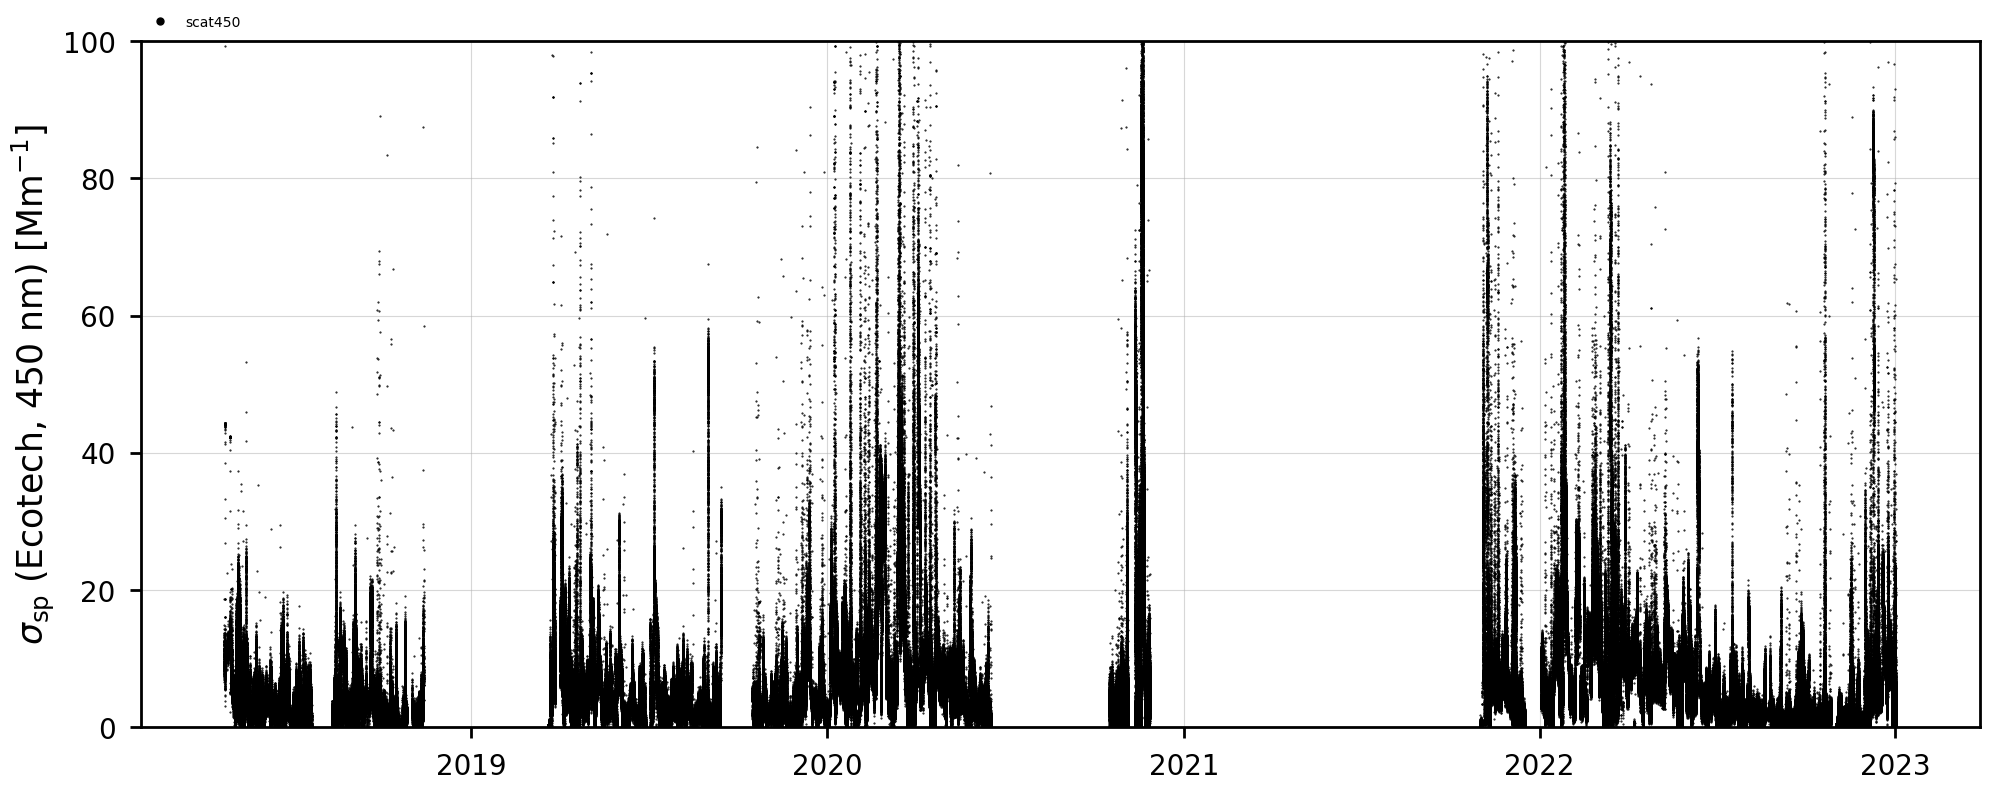

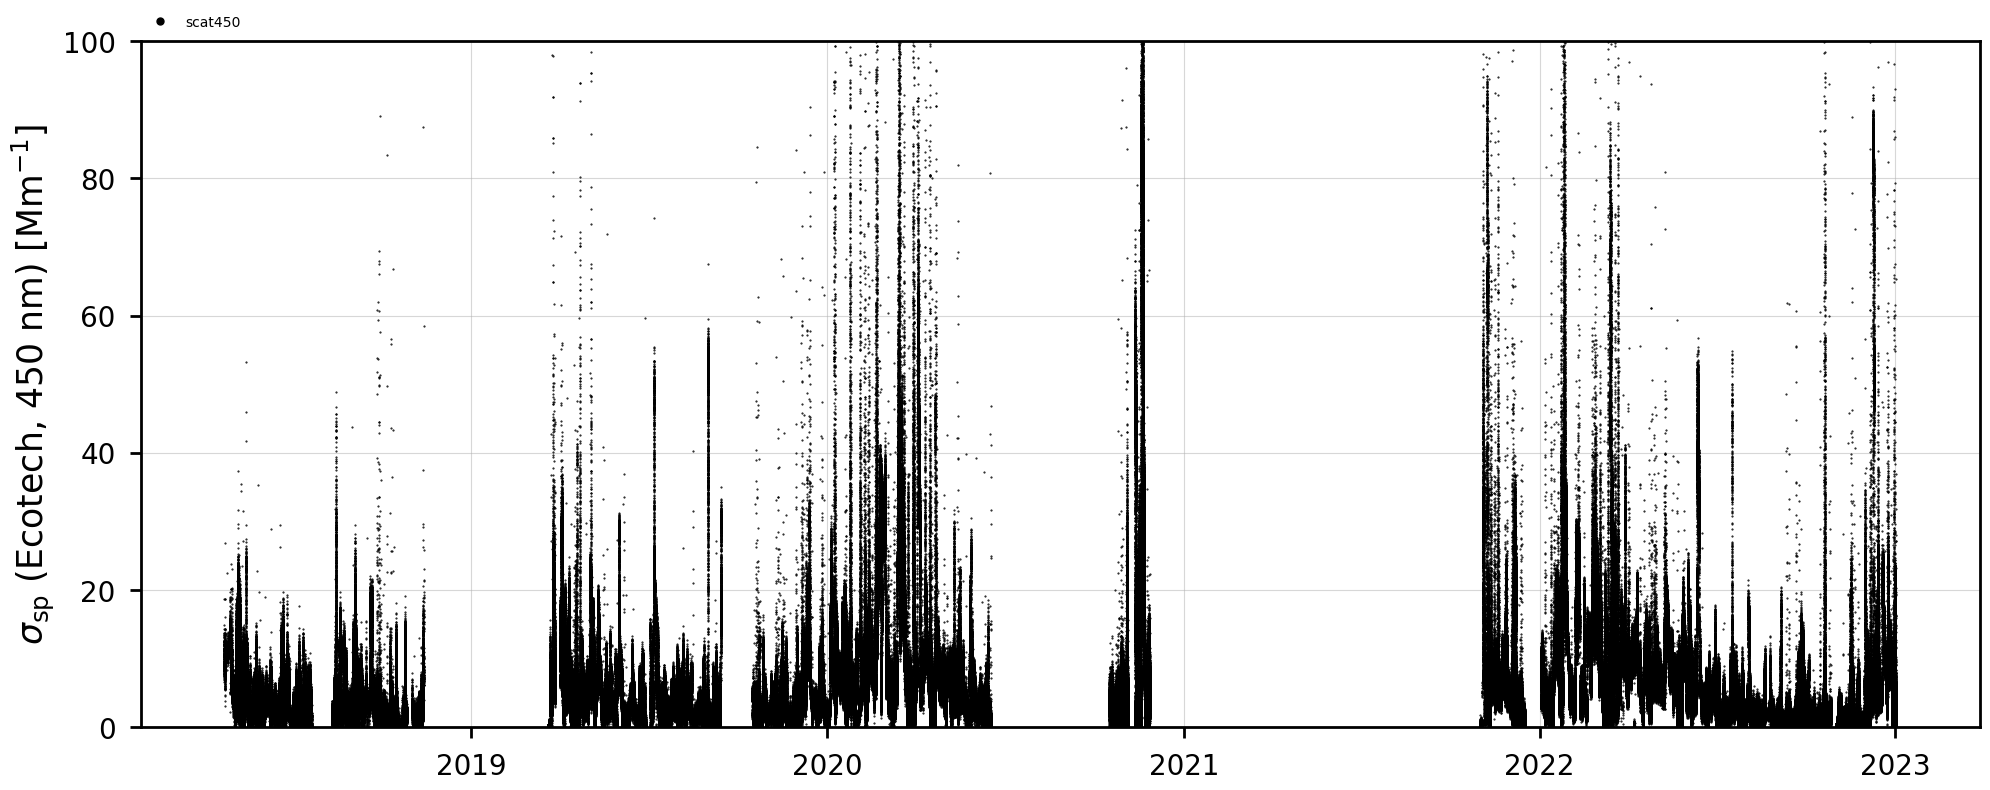

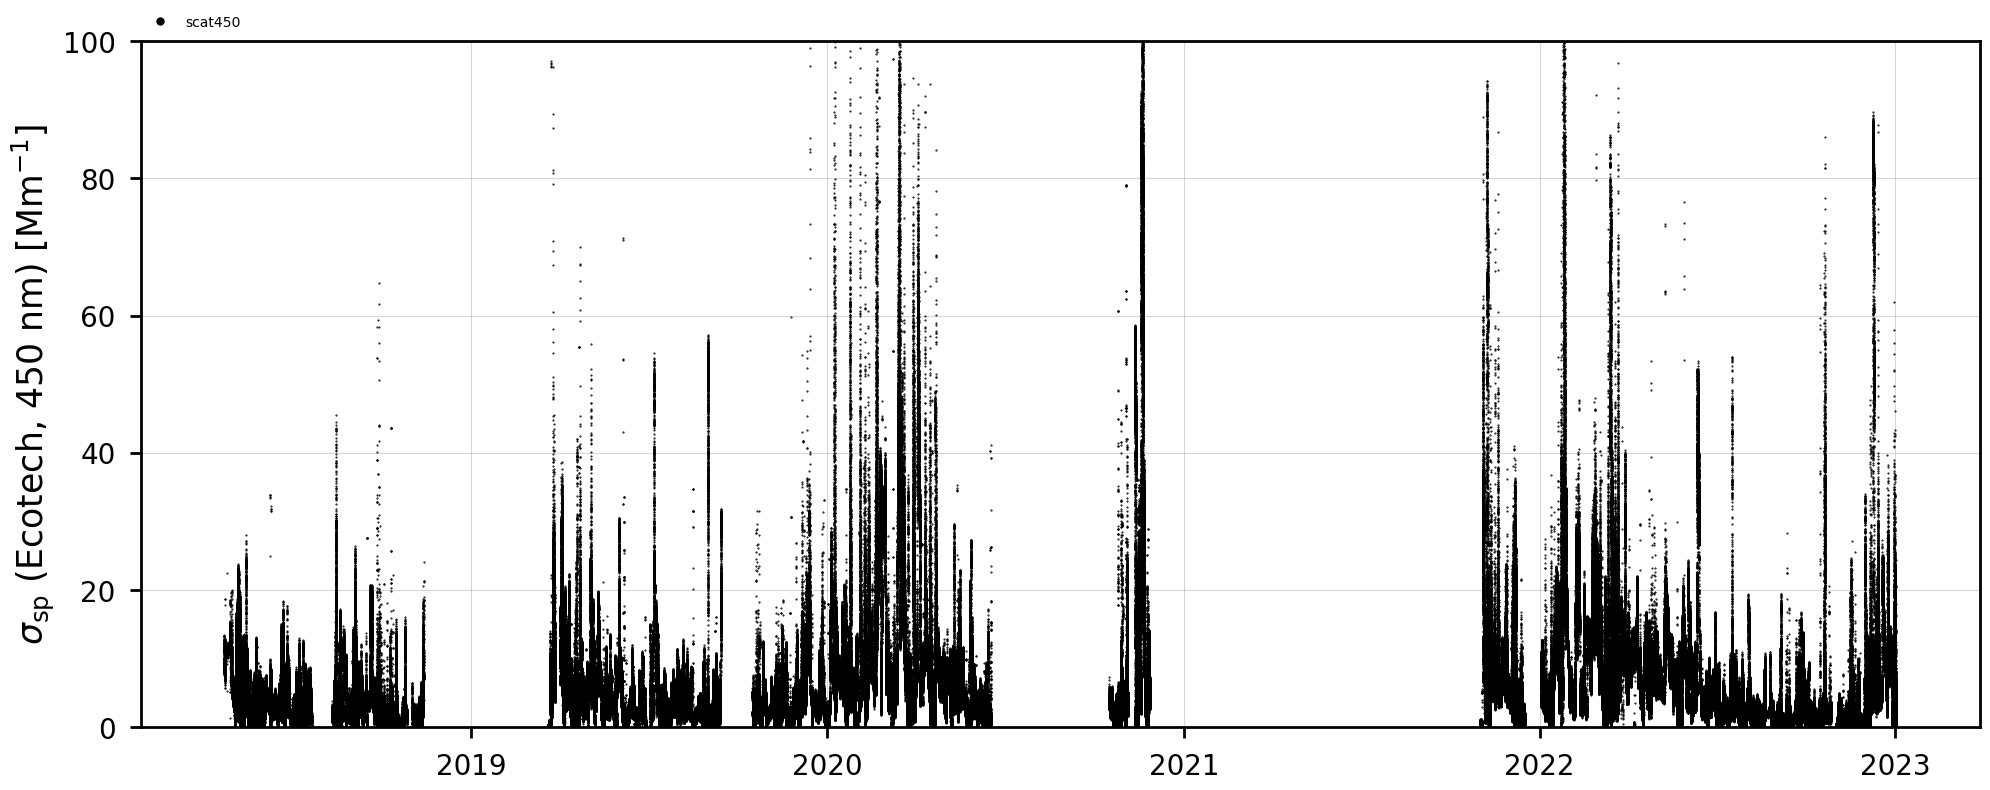

In [109]:
fig = simple_plot_hourly(df_CF, var='scat450', max_value=100)
fig = simple_plot_hourly(df_clean, var='scat450', max_value=100)
fig = simple_plot_hourly(df_LOD, var='scat450', max_value=100)

In [110]:
def drop_cols(LOD_cleaned_hourly_data, flagged_cleaned_hourly_data):
    drop_cols = [x for x in LOD_cleaned_hourly_data.columns if 'detection' in x] #drop detection cols
    LOD_cleaned_hourly_data = LOD_cleaned_hourly_data.drop(columns=drop_cols)

    LOD_cleaned_hourly_data = remove_duplicates(LOD_cleaned_hourly_data)

    #detection limits with flags
    frames = [LOD_cleaned_hourly_data, flagged_cleaned_hourly_data]
    LOD_cleaned_hourly_data_with_flagged_data = pd.concat(frames)
    LOD_cleaned_hourly_data_with_flagged_data = LOD_cleaned_hourly_data_with_flagged_data.sort_index()

    LOD_cleaned_hourly_data_with_flagged_data = remove_duplicates(LOD_cleaned_hourly_data_with_flagged_data)
    return LOD_cleaned_hourly_data_with_flagged_data

In [111]:
LOD_cleaned_hourly_data_with_flagged_data = drop_cols(df_cleaned_LOD_applied_hourly, df_flagged_hourly)

Length before: 41170
Duplicate Rows except first occurrence based on all columns are :0
Length after: 41170
Length before: 82307
Duplicate Rows except first occurrence based on all columns are :41137
Length after: 41170


In [112]:
noLOD_cleaned_hourly_data_with_flagged_data = drop_cols(df_cleaned_LOD_not_applied_hourly, df_flagged_hourly)

Length before: 41170
Duplicate Rows except first occurrence based on all columns are :0
Length after: 41170
Length before: 82307
Duplicate Rows except first occurrence based on all columns are :41137
Length after: 41170


In [113]:
LOD_cleaned_hourly_data_with_flagged_data.head(2)

,scat450,scat525,scat635,bscat450,bscat525,bscat635,p_int,T_int,RH_int,digital_flags,instru_flags,instrument_error,scat450_count,scat525_count,scat635_count,bscat450_count,bscat525_count,bscat635_count
datetime,,,,,,,,,,,,,,,,,,
2018-04-22 14:00:00,8.831231,7.79753,7.296213,1.103997,0.924575,0.882805,945.129627,24.776797,10.952572,0.0,0.0,0.0,51,51,51,51,51,51
2018-04-22 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60,60,60,60,60,60


In [114]:
LOD_cleaned_hourly_data_with_flagged_data.columns

Index(['scat450', 'scat525', 'scat635', 'bscat450', 'bscat525', 'bscat635',
       'p_int', 'T_int', 'RH_int', 'digital_flags', 'instru_flags',
       'instrument_error', 'scat450_count', 'scat525_count', 'scat635_count',
       'bscat450_count', 'bscat525_count', 'bscat635_count'],
      dtype='object')

In [115]:
def simple_plot_hourly(df, var='scat450', max_value=100, ylabel='',
                      figsize_x=20, figsize_y=4):
    fig, ax = plt.subplots(1, figsize=(figsize_x, figsize_y))

    ax.plot(df.index, df[var],'o', ms=0.5, c='k', label=str(var))
       
    ax.set_ylabel(ylabel, fontsize=25)
    fancy(ax) 
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01),
            borderaxespad=0, frameon=False, markerscale=10,)

    ax.set_ylim(0, max_value)
    plt.tight_layout()
    plt.show()
    return fig

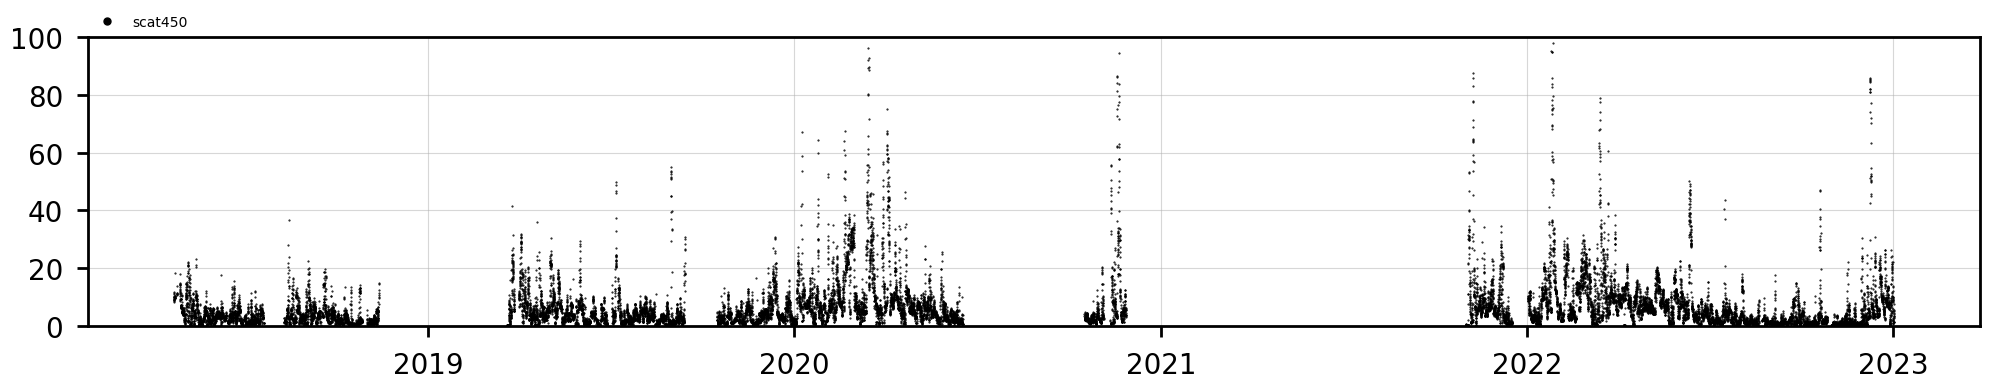

In [116]:
fig = simple_plot_hourly(df_cleaned_LOD_applied_hourly, var='scat450', max_value=100)

In [117]:
def calculate_all_AEs(df, dict_of_variables):
    wavelengths = dict_of_variables['wavelengths'] 
    correction_factors = dict_of_variables['correction_factors'] 
    cols_wavelengths = dict_of_variables['cols_wavelengths'] 

    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths,  
                      colour1='blue', colour2='green', AE_name='blue') #Angstrom Exponent at 450nm
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths, 
                      colour1='blue', colour2='red', AE_name='green')   #Angstrom Exponent at 550nm
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths, 
                      colour1='green', colour2='red', AE_name='red')  #Angstrom Exponent at 700nm
    
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths,  
                      colour1='blue', colour2='green', AE_name='blue', bscat='b') #Angstrom Exponent at 450nm
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths,  
                      colour1='blue', colour2='red', AE_name='green', bscat='b')   #Angstrom Exponent at 550nm
    df = calculate_AE(df, wavelengths, correction_factors, cols_wavelengths,  
                      colour1='green', colour2='red', AE_name='red', bscat='b')  #Angstrom Exponent at 700nm
    return df

def convert_wavelength(df, AE_col, scat1, scat2):   
    scat_converted = df['scat'+str(scat1)]*(scat1/scat2)**df['AE_'+str(AE_col)] #scat550 = df_AE.scat525*(525/550)**AE_525
    df['scat'+str(scat2)] = scat_converted
    bscat_converted = df['bscat'+str(scat1)]*(scat1/scat2)**df['bAE_'+str(AE_col)] #bscat550 = df_AE.bscat525*(525/550)**AE_525
    df['bscat'+str(scat2)] = scat_converted
    return df
    
def convert_wavelength_for_files(LOD_cleaned_hourly_data_with_flagged_data, noLOD_cleaned_hourly_data_with_flagged_data,
                       ):
    LOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(LOD_cleaned_hourly_data_with_flagged_data, 
                                                                   AE_col=450, scat1=525, scat2=550)
    LOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(LOD_cleaned_hourly_data_with_flagged_data, 
                                                                   AE_col=450, scat1=525, scat2=530)
    LOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(LOD_cleaned_hourly_data_with_flagged_data, 
                                                                   AE_col=525, scat1=635, scat2=700)
    LOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(LOD_cleaned_hourly_data_with_flagged_data, 
                                                                   AE_col=525, scat1=635, scat2=637)
    
    noLOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(noLOD_cleaned_hourly_data_with_flagged_data, 
                                                                     AE_col=450, scat1=525, scat2=550)
    noLOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(noLOD_cleaned_hourly_data_with_flagged_data, 
                                                                     AE_col=450, scat1=525, scat2=530)
    noLOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(noLOD_cleaned_hourly_data_with_flagged_data, 
                                                                     AE_col=525, scat1=635, scat2=700)
    noLOD_cleaned_hourly_data_with_flagged_data = convert_wavelength(noLOD_cleaned_hourly_data_with_flagged_data, 
                                                                     AE_col=525, scat1=635, scat2=637)
    return LOD_cleaned_hourly_data_with_flagged_data, noLOD_cleaned_hourly_data_with_flagged_data
    
def move_col_to_end(df, flag_cols=['digital_flags', 'instru_flags', 'instrument_error']):
    print(flag_cols)
    if 'Flag' in df.columns:
        print("drop Flag col:")
        df = df.drop(columns=['Flag'])
    for flag_col in flag_cols:
        df.insert(len(df.columns)-1, flag_col, df.pop(flag_col))
    return df
    
def drop_bAE(df): 
    bAE_cols = [x for x in df.columns if 'bAE' in x]
    print(bAE_cols)
    df = df.drop(columns=bAE_cols)
    return df
        
def select_zero_flags(df):
    df = df[(df['digital_flags'] == 0) & (df['instru_flags'] == 0) & (df['instrument_error'] == 0)]
    df = df.drop(columns=['digital_flags', 'instru_flags', 'instrument_error'])
    return df

In [118]:
flag_cols

['digital_flags', 'instru_flags', 'instrument_error']

In [119]:
LOD_cleaned_hourly_data_with_flagged_data = calculate_all_AEs(LOD_cleaned_hourly_data_with_flagged_data, 
                                                                      dict_of_variables)
noLOD_cleaned_hourly_data_with_flagged_data = calculate_all_AEs(noLOD_cleaned_hourly_data_with_flagged_data, 
                                                                        dict_of_variables)

wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]
wavelengths: [450, 525, 635]


C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [120]:
LOD_cleaned_hourly_data_with_flagged_data, noLOD_cleaned_hourly_data_with_flagged_data = convert_wavelength_for_files(LOD_cleaned_hourly_data_with_flagged_data, 
                                                                           noLOD_cleaned_hourly_data_with_flagged_data,
                                                                            )

# Save ecotech data: 

In [121]:
def save_df(df, path, name='default_name', folder=None, float_format='%.3f'):  
    print("path: "+str(path))
    folders = glob.glob(path)
    print("folders in path: "+str(folders))    
    if folder is not None:        
        if folder not in folders:
            print("make folder")
            os.makedirs(path+folder, exist_ok=True)        
        print("Save as: "+str(path+folder+"\\"+name+'.dat'))
        df.to_csv(path+folder+"\\"+name+'.dat',index=True, float_format=float_format)
    if folder == None:
        df.to_csv(path+name+'.dat',index=True, float_format=float_format)
        
def create_name(dict_of_variables):
    years = dict_of_variables['years']
    name_all_years = str(years.tolist()).replace(' ','').replace(']','').replace('[','').replace(',','')
    name = name_all_years[:4]+'_'+name_all_years[-4:]
    return name

In [122]:
dict_of_variables

{'wavelengths': [450, 525, 635],
 'correction_factors': [(1.455, -0.189), (1.434, -0.176), (1.403, -0.156)],
 'cols_wavelengths': ['scat450', 'scat525', 'scat635'],
 'detection_limits': [0.1, 0.13, 0.11, 0.09, 0.11, 0.12],
 'varlist': ['scat450',
  'scat525',
  'scat635',
  'bscat450',
  'bscat525',
  'bscat635',
  'p_int',
  'T_int',
  'RH_int'],
 'years': array([2018, 2019, 2020, 2021, 2022, 2023]),
 'parse_dates': ['DOY'],
 'index_col': ['DOY'],
 'types_dict': {'EPOCH': 'float64',
  'F1_S13': 'object',
  'F2_S13': 'object',
  'BsB_S13': 'float64',
  'BsG_S13': 'float64',
  'BsR_S13': 'float64',
  'BbsB_S13': 'float64',
  'BbsG_S13': 'float64',
  'BbsR_S13': 'float64',
  'CcB_S13': 'float64',
  'CcG_S13': 'float64',
  'CcR_S13': 'float64',
  'CbcB_S13': 'float64',
  'CbcG_S13': 'float64',
  'CbcR_S13': 'float64',
  'T_S13': 'float64',
  'U_S13': 'float64',
  'P_S13': 'float64',
  'BbswB_S13': 'float64',
  'BbswG_S13': 'float64',
  'BbswR_S13': 'float64',
  'BswB_S13': 'float64',
  'B

In [123]:
LOD_cleaned_hourly_data_with_flagged_data = move_col_to_end(LOD_cleaned_hourly_data_with_flagged_data)
LOD_cleaned_hourly_data_with_flagged_data = drop_bAE(LOD_cleaned_hourly_data_with_flagged_data)

name = create_name(dict_of_variables)
print(name)
number_of_duplicates(LOD_cleaned_hourly_data_with_flagged_data)

###SAVE WITH FLAGS
save_df(LOD_cleaned_hourly_data_with_flagged_data, name=name+"_LOD_flagged", path=outpath_files,
       folder='flagged_'+str(name))

['digital_flags', 'instru_flags', 'instrument_error']
['bAE_450', 'bAE_525', 'bAE_635']
2018_2023
Length before: 41170
Number of duplicated indexes :
0
path: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\ecotech\
folders in path: ['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Neph\\ecotech\\']
make folder
Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\ecotech\flagged_2018_2023\2018_2023_LOD_flagged.dat


In [124]:
noLOD_cleaned_hourly_data_with_flagged_data = move_col_to_end(noLOD_cleaned_hourly_data_with_flagged_data)
noLOD_cleaned_hourly_data_with_flagged_data = drop_bAE(noLOD_cleaned_hourly_data_with_flagged_data)

name = create_name(dict_of_variables)
number_of_duplicates(noLOD_cleaned_hourly_data_with_flagged_data)

#SAVE WITH FLAGS 

save_df(noLOD_cleaned_hourly_data_with_flagged_data, name=name+"_noLOD_flagged", path=outpath_files, folder='flagged_'+str(name))

['digital_flags', 'instru_flags', 'instrument_error']
['bAE_450', 'bAE_525', 'bAE_635']
Length before: 41170
Number of duplicated indexes :
0
path: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\ecotech\
folders in path: ['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Neph\\ecotech\\']
make folder
Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\ecotech\flagged_2018_2023\2018_2023_noLOD_flagged.dat


## no flags: 

In [125]:
LOD_cleaned_hourly_data = select_zero_flags(LOD_cleaned_hourly_data_with_flagged_data)
noLOD_cleaned_hourly_data = select_zero_flags(noLOD_cleaned_hourly_data_with_flagged_data)

In [126]:
LOD_cleaned_hourly_data.head(2)

,scat450,scat525,scat635,bscat450,bscat525,bscat635,p_int,T_int,RH_int,scat450_count,...,AE_525,AE_635,scat550,bscat550,scat530,bscat530,scat700,bscat700,scat637,bscat637
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-22 14:00:00,8.831231,7.797530,7.296213,1.103997,0.924575,0.882805,945.129627,24.776797,10.952572,51,...,0.554447,0.349328,7.510026,7.510026,7.738070,7.738070,6.912433,6.912433,7.283503,7.283503
2018-04-22 16:00:00,9.232571,7.945371,7.241873,1.256525,1.039885,0.858126,945.320874,25.066612,10.690546,61,...,0.705208,0.487364,7.593385,7.593385,7.872352,7.872352,6.760883,6.760883,7.225831,7.225831


In [127]:
LOD_cleaned_hourly_data[['scat450_count', 'scat525_count', 'scat635_count',
       'bscat450_count', 'bscat525_count', 'bscat635_count']].min()

scat450_count     0
scat525_count     0
scat635_count     0
bscat450_count    1
bscat525_count    1
bscat635_count    1
dtype: int64

In [128]:
LOD_cleaned_hourly_data.columns

Index(['scat450', 'scat525', 'scat635', 'bscat450', 'bscat525', 'bscat635',
       'p_int', 'T_int', 'RH_int', 'scat450_count', 'scat525_count',
       'scat635_count', 'bscat450_count', 'bscat525_count', 'bscat635_count',
       'AE_450', 'AE_525', 'AE_635', 'scat550', 'bscat550', 'scat530',
       'bscat530', 'scat700', 'bscat700', 'scat637', 'bscat637'],
      dtype='object')

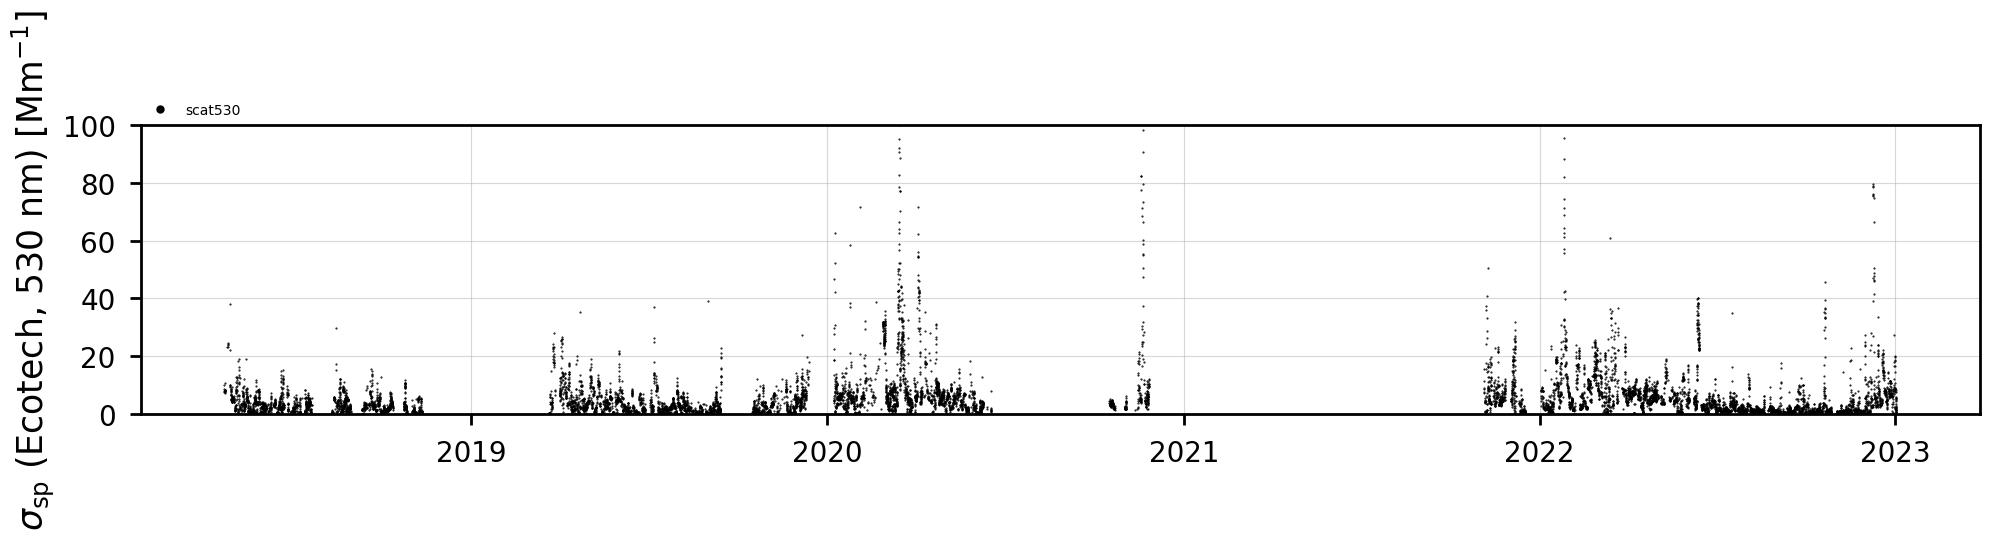

In [129]:
fig = simple_plot_hourly(LOD_cleaned_hourly_data, var='scat530', max_value=100, 
                        ylabel='$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(530)+' nm) [Mm$^{-1}$]')

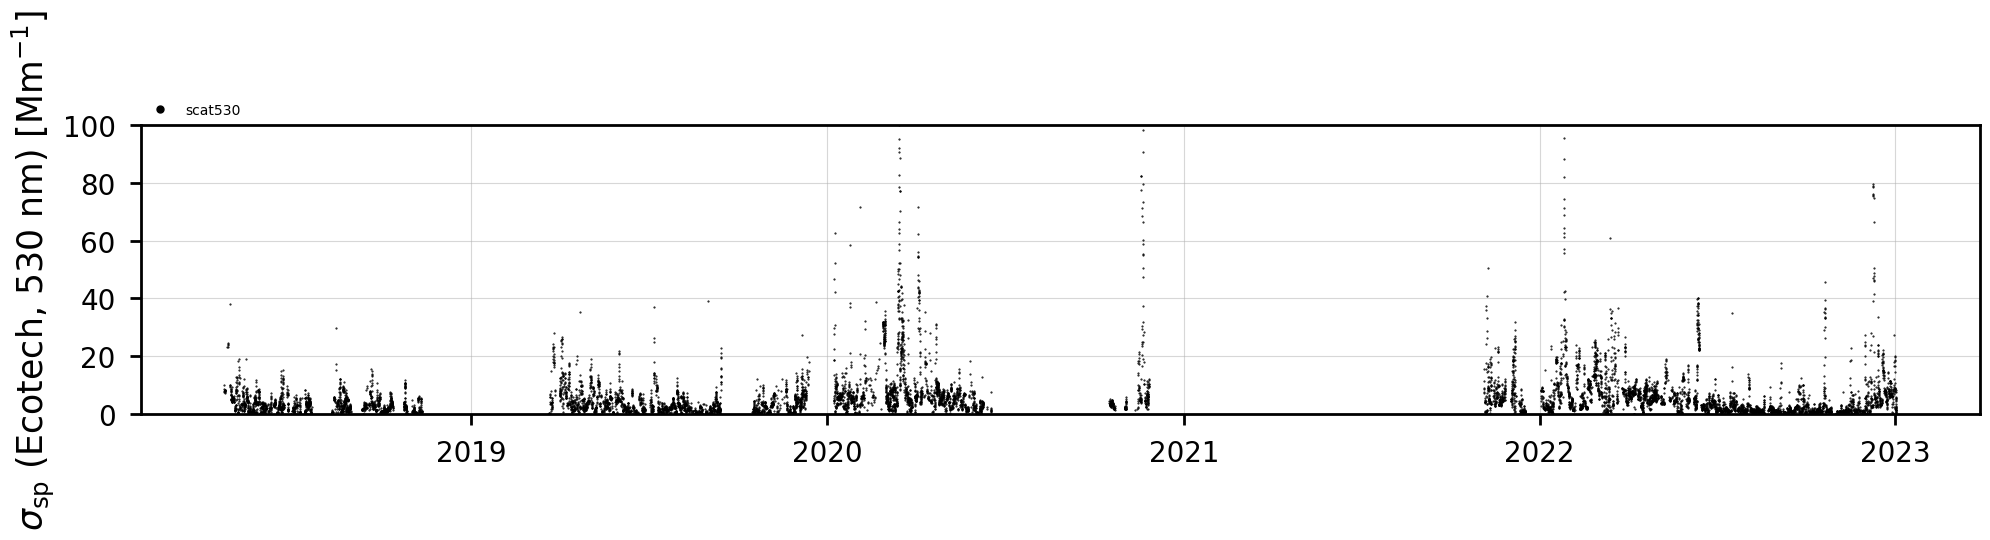

In [130]:
fig = simple_plot_hourly(noLOD_cleaned_hourly_data, var='scat530', max_value=100, 
                        ylabel='$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(530)+' nm) [Mm$^{-1}$]')

In [131]:
save_df(LOD_cleaned_hourly_data, 
        outpath_files, 
        name='LOD_cleaned_hourly_ecotech_data', 
        folder=None)

path: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\ecotech\
folders in path: ['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Neph\\ecotech\\']


In [132]:
save_df(noLOD_cleaned_hourly_data, 
        outpath_files, 
        name='noLOD_cleaned_hourly_ecotech_data', 
        folder=None)

path: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\ecotech\
folders in path: ['C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Neph\\ecotech\\']


In [133]:
savepath = outpath_files
noLOD_cleaned_hourly_data.to_csv(savepath+'\\noLOD_hourly_ecotech_mean_ZEP.dat',index=True, float_format='%.3f')
LOD_cleaned_hourly_data.to_csv(savepath+'\\LOD_hourly_ecotech_mean_ZEP.dat',index=True, float_format='%.3f')

In [134]:
def read_optical_data(year, outpath_files, types_dict, folder):    
    df = pd.read_csv(outpath_files+"\\"+str(folder)+"\\"+str(year)+".dat", parse_dates=['date'], index_col=['date'], dtype=types_dict)  
    df = df.dropna(how='all') #remove rows containing all np.nan - needless 
    return df

In [135]:
path = outpath_files+"LOD_hourly_ecotech_mean_ZEP.dat"
df_LOD = pd.read_csv(path,index_col=0)
df_LOD.index = pd.to_datetime(df_LOD.index)

path = outpath_files+"noLOD_hourly_ecotech_mean_ZEP.dat"
df_noLOD = pd.read_csv(path,index_col=0)
df_noLOD.index = pd.to_datetime(df_noLOD.index)

In [136]:
def simple_2plot_hourly(df1, df2, var1='scat450', var2='scat450', max_value=100, ylabel=''):
    fig, ax = plt.subplots(1, figsize=(15,4))
    ax.plot(df1.index, df1[var1],'o', ms=2, c='k', alpha=1, label='LOD: '+str(len(df1)))
    ax.plot(df2.index, df2[var2],'o', ms=2, c='b', alpha=.5, label='noLOD: '+str(len(df2)))       
    ax.set_ylabel(ylabel, fontsize=20)
    fancy(ax) 
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01),
            borderaxespad=0, frameon=False, markerscale=5, ncol=2, fontsize=20)
    
    if max_value is not None:
        ax.set_ylim(-10, max_value)
    plt.xlim(pd.to_datetime(LOD_cleaned_hourly_data.index[0]), 
             pd.to_datetime(LOD_cleaned_hourly_data.index[-1]))
    plt.tight_layout()
    plt.show()
    return fig

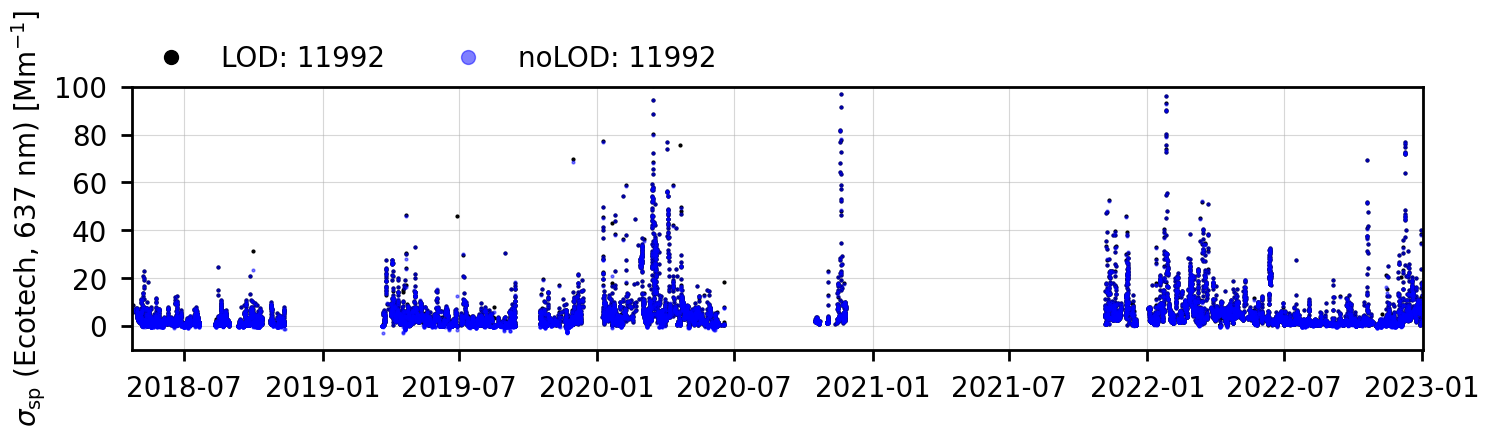

In [137]:
fig = simple_2plot_hourly(df_LOD, df_noLOD,
                   var1='scat637', var2='scat635', max_value=100,
                        ylabel='$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(637)+' nm) [Mm$^{-1}$]')

In [138]:
def simple_plot_hourly(df, var='scat450', max_value=100, ylabel='',
                      figsize_x=20, figsize_y=4, ms=0.5):
    fig, ax = plt.subplots(1, figsize=(figsize_x, figsize_y))

    ax.plot(df.index, df[var],'o', ms=ms, c='k', label=str(var))
       
    ax.set_ylabel(ylabel, fontsize=25)
    fancy(ax) 
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01),
            borderaxespad=0, frameon=False, markerscale=2,)

    ax.set_ylim(-1, max_value)
    plt.tight_layout()
    plt.show()
    return fig

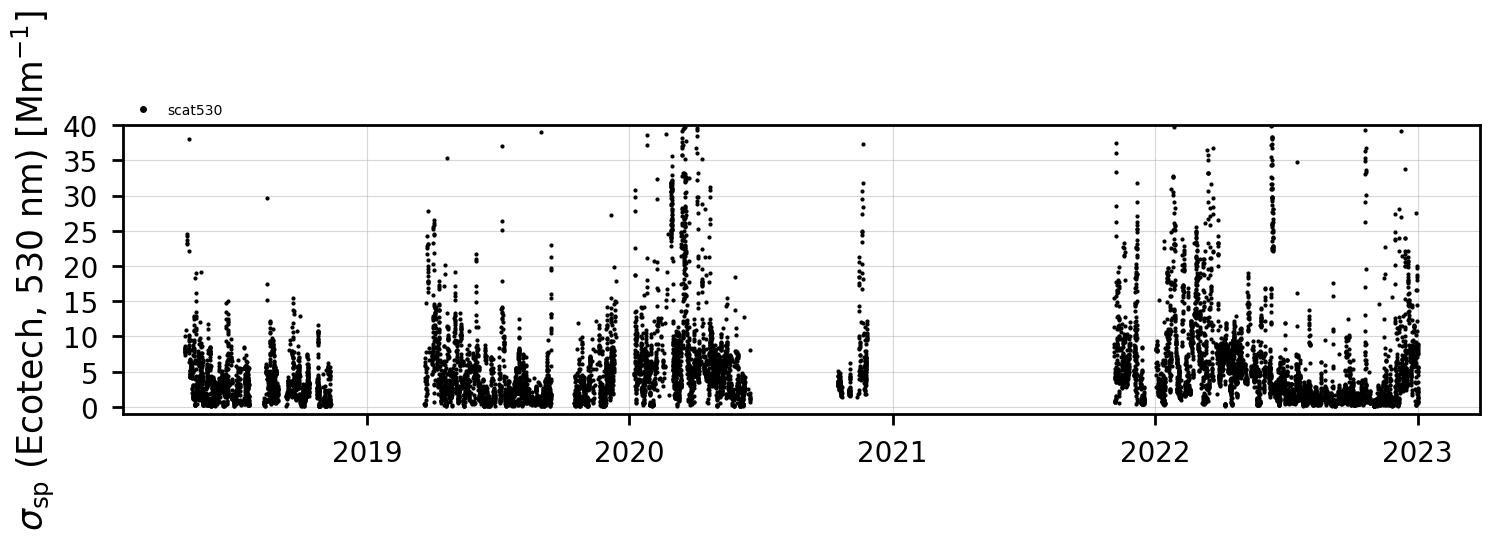

In [139]:
fig = simple_plot_hourly(df_LOD, var='scat530', max_value=40, 
                        ylabel='$\sigma_{\mathrm{sp}}$ (Ecotech, '+str(530)+' nm) [Mm$^{-1}$]',
                        figsize_x=15, figsize_y=4, ms=2)

In [140]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.4
pandas==1.3.3
csv==1.0
cmocean==2.0
